# 快速开始：MNIST 从训练到预测服务

本示例演示使用 Notebook 开发调试、可视化工作流创建以及模型服务管理，完成使用 Tensorflow 训练手写数字识别模型 (MNIST)，在训练任务页面中查看可视化内容，最后启动手写数字识别模型的 HTTP 服务并预测新的数据。


## 准备数据

本教程使用的数据是基于 [MNIST](https://www.tensorflow.org/datasets/catalog/mnist?hl=zh-cn) 数据集构建。数据集已经预制在当前 Notebook `datasets/mnist` 目录下。如果需要自行下载，可以参考上述链接。

在 Kubeflow 实际使用场景中，我们会将数据上传到 S3 中统一存储，并使用 `boto3` 或 `tf.data.Dataset` 相关的 API 读取。对于非 `TFRecord` 格式数据，也可以自定义数据集处理代码。我们先将预制的数据集上传到 MinIO 存储中:



1. (可选) 如果没有预先安装 `boto3` 则需要先安装 `boto3`，以支持 s3 文件上传：

In [1]:
!pip install -q boto3 -i https://pypi.tuna.tsinghua.edu.cn/simple


2. 创建 `dataset` bucket，并上传数据（endpoint_url, 账号，密码请和管理员申请）：

In [2]:
import boto3

s3 = boto3.resource(
    "s3", endpoint_url="http://minio-service.kubeflow:9000", aws_access_key_id="minio", aws_secret_access_key="minio123"
)

flist = ["datasets/mnist/mnist-train.tfrecord-00000-of-00001", "datasets/mnist/mnist-test.tfrecord-00000-of-00001"]
bucket = s3.Bucket("dataset")
if not bucket.creation_date:
    bucket = s3.create_bucket(Bucket="dataset")
for src in flist:
    dst = "/".join(src.split("/")[1:])
    print("uploading ", dst)
    s3.meta.client.upload_file(src, 'dataset', dst)
print("done")


uploading  mnist/mnist-train.tfrecord-00000-of-00001
uploading  mnist/mnist-test.tfrecord-00000-of-00001
done


## 使用 GPU

您可以在 Notebook 和 提交工作流任务（pipeline）时使用 GPU。但注意 Notebook 和工作流会单独占用 GPU 资源，您需要确定完整的训练任务是要在 Notebook 运行还是提交工作流运行，请选择其一，否则会浪费资源。

在下面的例子中，使用 GPU 的方法也会有具体说明。

## 编写代码并在 Notebook 中运行

下面代码使用定义了一个简单的 CNN 深度学习模型，完成模型的训练，可以在 Notebook 中测试运行以调试模型代码。

如果要在 Notebook 中使用 GPU 训练，需要在启动 Notebook 时使用支持 CUDA 的镜像，并申请 GPU 资源（或 vGPU 资源）：

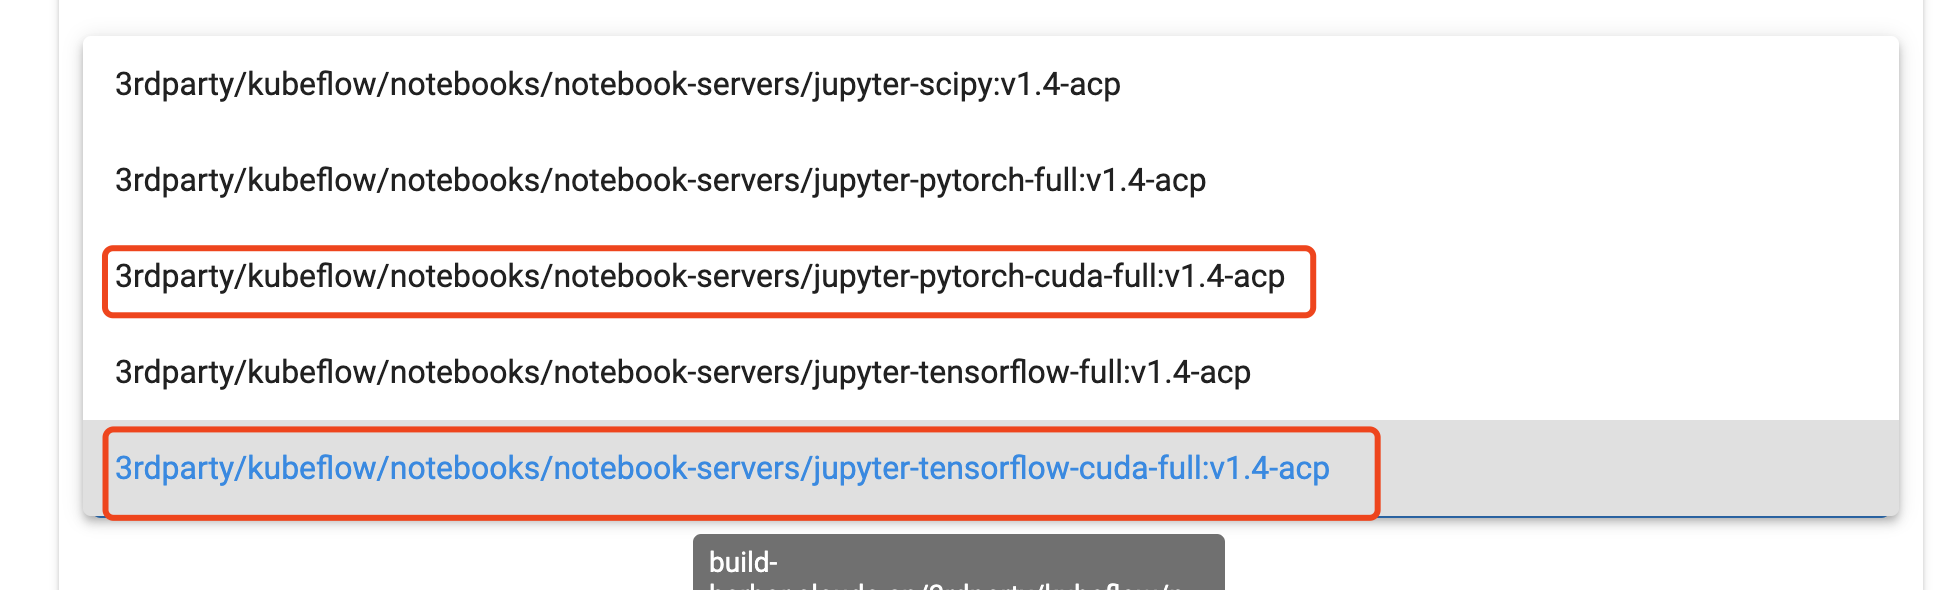

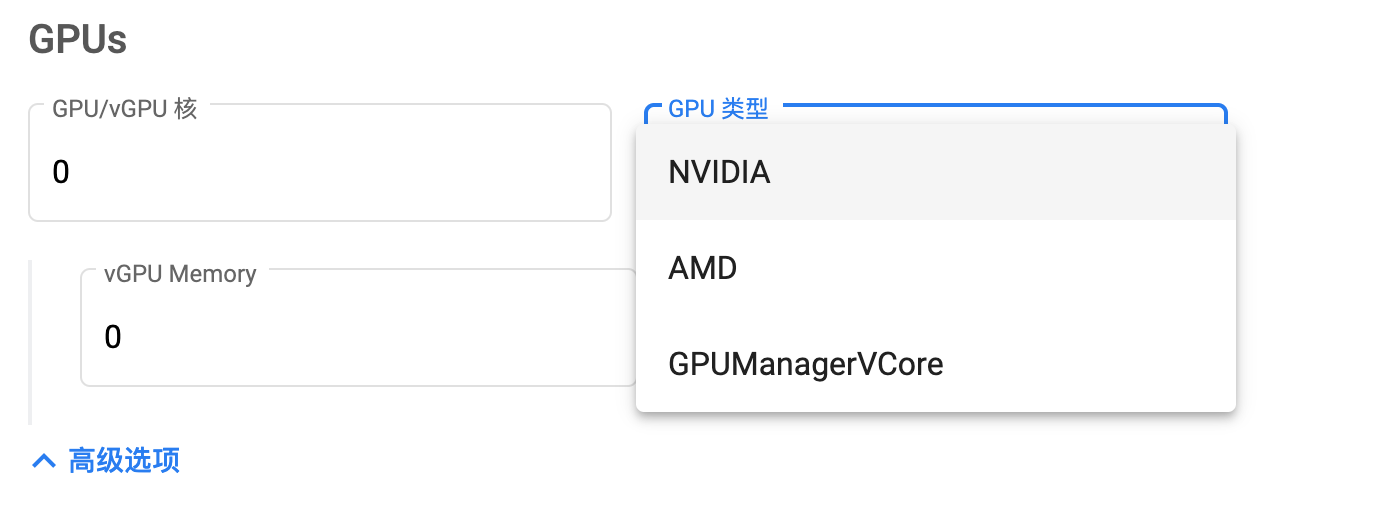


然后编写支持使用 GPU 训练的代码。下面示例代码使用了 Keras `model.fit` API 会自动判断是是否有可用 GPU，如果有就会尝试使用。如果要查看 GPU 资源使用情况，可以执行下面命令查看（只有有 GPU 时才可以执行）：

In [ ]:
!nvidia-smi


以下是模型定义和训练代码，执行下面代码即可以在 Notebook 中完成模型调试和训练：

In [3]:
import boto3
import tensorflow as tf
from tensorflow.keras import layers
import os
import mlflow
import mlflow.tensorflow

mlflow.tensorflow.autolog()

s3 = boto3.resource(
    's3',
    endpoint_url='http://minio-service.kubeflow:9000',
    aws_access_key_id='minio',
    aws_secret_access_key='minio123')
# s3://dataset/mnist/mnist-train.tfrecord-00000-of-00001
# s3://dataset/mnist/mnist-test.tfrecord-00000-of-00001
s3.Bucket('dataset').download_file('mnist/mnist-train.tfrecord-00000-of-00001', '/tmp/mnist-train.tfrecord-00000-of-00001')
s3.Bucket('dataset').download_file('mnist/mnist-test.tfrecord-00000-of-00001', '/tmp/mnist-test.tfrecord-00000-of-00001')

files_train = ["/tmp/mnist-train.tfrecord-00000-of-00001"]
files_test = ["/tmp/mnist-test.tfrecord-00000-of-00001"]

ds_train = tf.data.TFRecordDataset(files_train)
ds_test = tf.data.TFRecordDataset(files_test)

input_shape = (28, 28, 1)
num_classes = 10

# 定义数据预处理：
def normalize_img(record):
    features = {"image": tf.io.FixedLenFeature([], tf.string), "label": tf.io.FixedLenFeature([1], tf.int64)}
    feats = tf.io.parse_single_example(record, features)
    img = tf.image.decode_image(feats["image"], channels=1, dtype=tf.uint8)
    img.set_shape(input_shape)

    label = feats["label"]
    return tf.cast(img, tf.float32) / 255.0, label


ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(100)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

# 定义模型结构：
model = tf.keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)


# 开始训练：
with mlflow.start_run() as run:
    history = model.fit(
        ds_train,
        epochs=2,
        validation_data=ds_test
    )
    print(history.history)


2023/04/10 02:38:10 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2023-04-10 02:38:10.999727: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-10 02:38:10.999775: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-10 02:38:10.999841: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tutorial-0): /proc/driver/nvidia/version does not exist
2023-04-10 02:38:11.009173: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in per

Epoch 1/2
469/469 [==============================] - 23s 48ms/step - loss: 0.3451 - sparse_categorical_accuracy: 0.8939 - val_loss: 0.0898 - val_sparse_categorical_accuracy: 0.9737
Epoch 2/2
469/469 [==============================] - 18s 38ms/step - loss: 0.1083 - sparse_categorical_accuracy: 0.9671 - val_loss: 0.0606 - val_sparse_categorical_accuracy: 0.9815


INFO:tensorflow:Assets written to: /tmp/tmp63b9yh0t/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp63b9yh0t/model/data/model/assets
2023/04/10 02:39:03 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/conda/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
2023/04/10 02:39:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Unable to locate credentials


{'loss': [0.34511181712150574, 0.10828827321529388], 'sparse_categorical_accuracy': [0.8938666582107544, 0.96711665391922], 'val_loss': [0.08980865031480789, 0.06055999919772148], 'val_sparse_categorical_accuracy': [0.9736999869346619, 0.9815000295639038]}


## 可视化工作流任务创建

***在开始之前，请先按照《00可视化开发环境配置》完成相关前置配置***

1. 将上面的代码创建为一个 `mnist_train.py` Python文件（示例代码已经在src/mnist_train.py）
2. 新建一个可视化开发任务（也可以参考 `01mnist.pipeline`），将第1步中的 Python 文件拖拽到面板中：

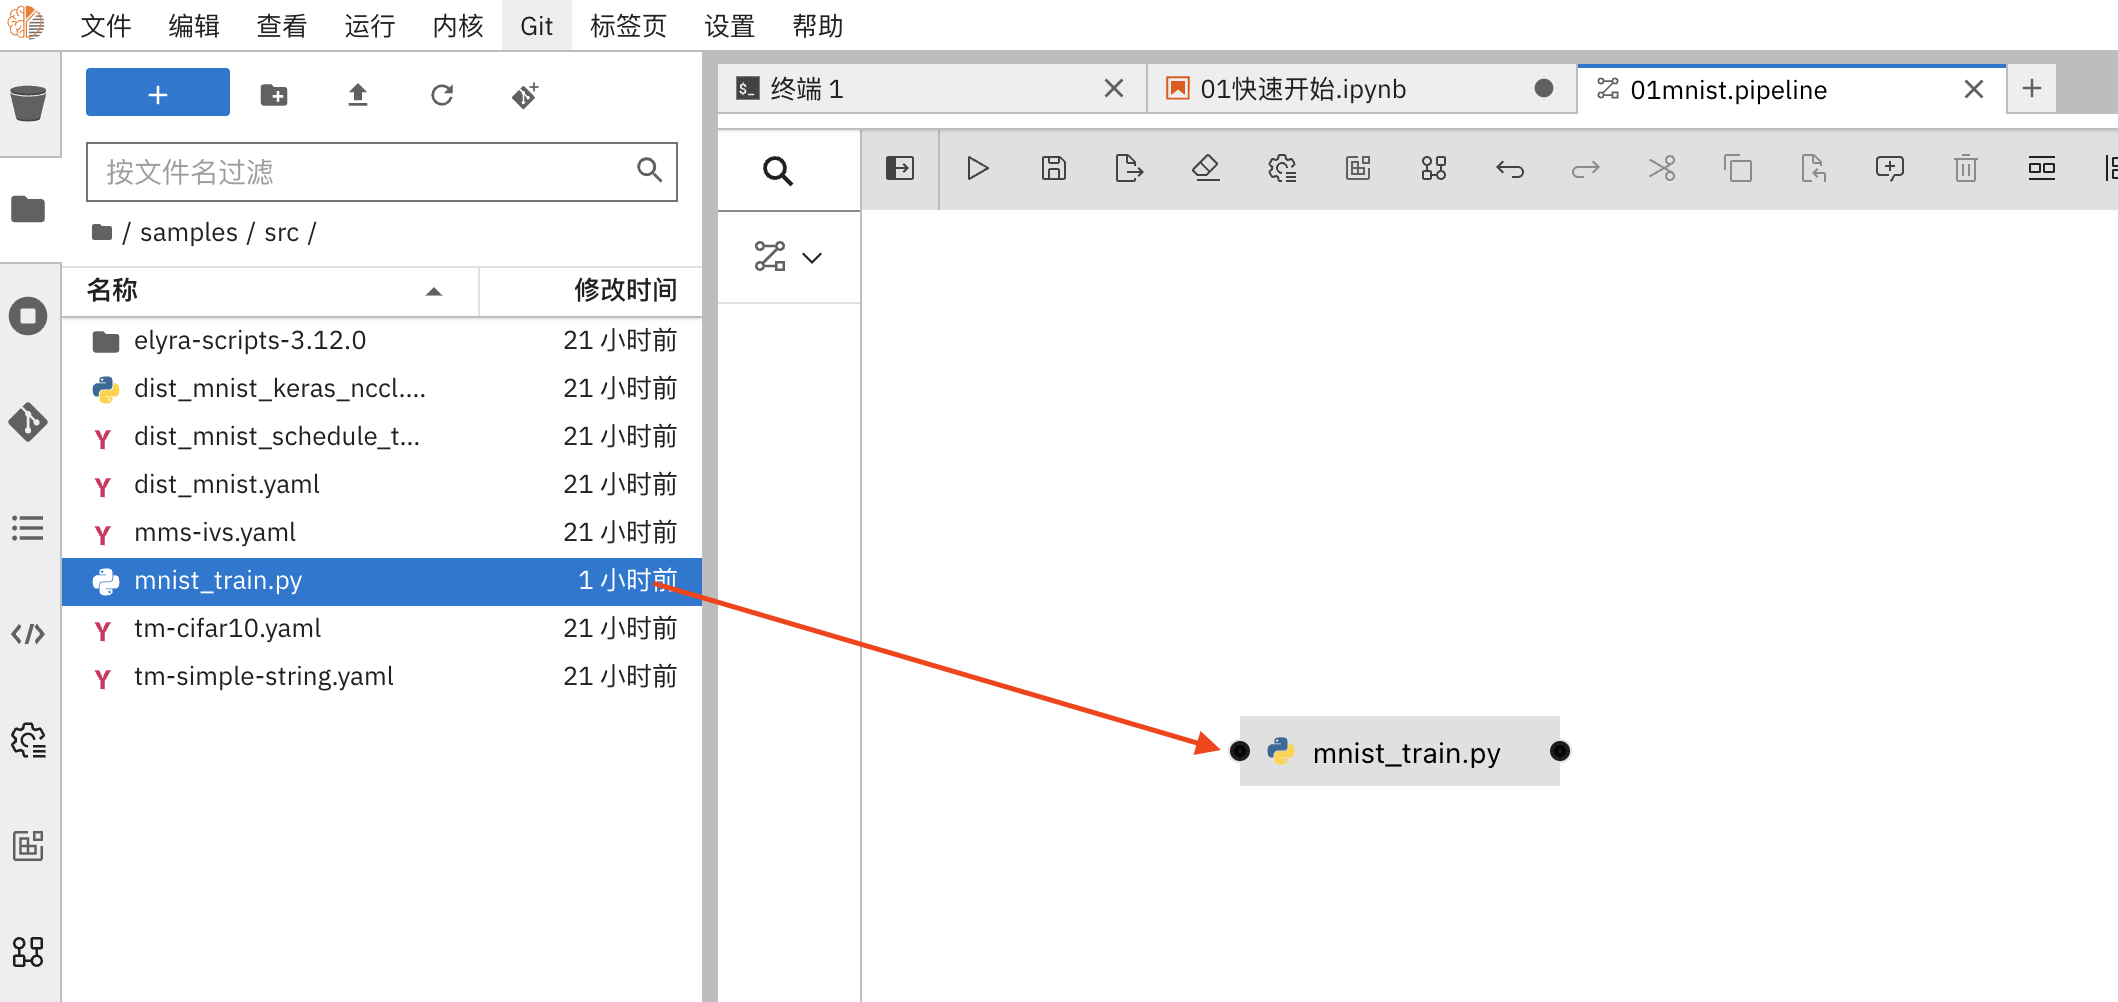
3. 配置这个步骤运行时需要的镜像，环境变量，输入输出等信息。注意，如果希望保存输出的模型，要填写输出的文件、目录的路径。

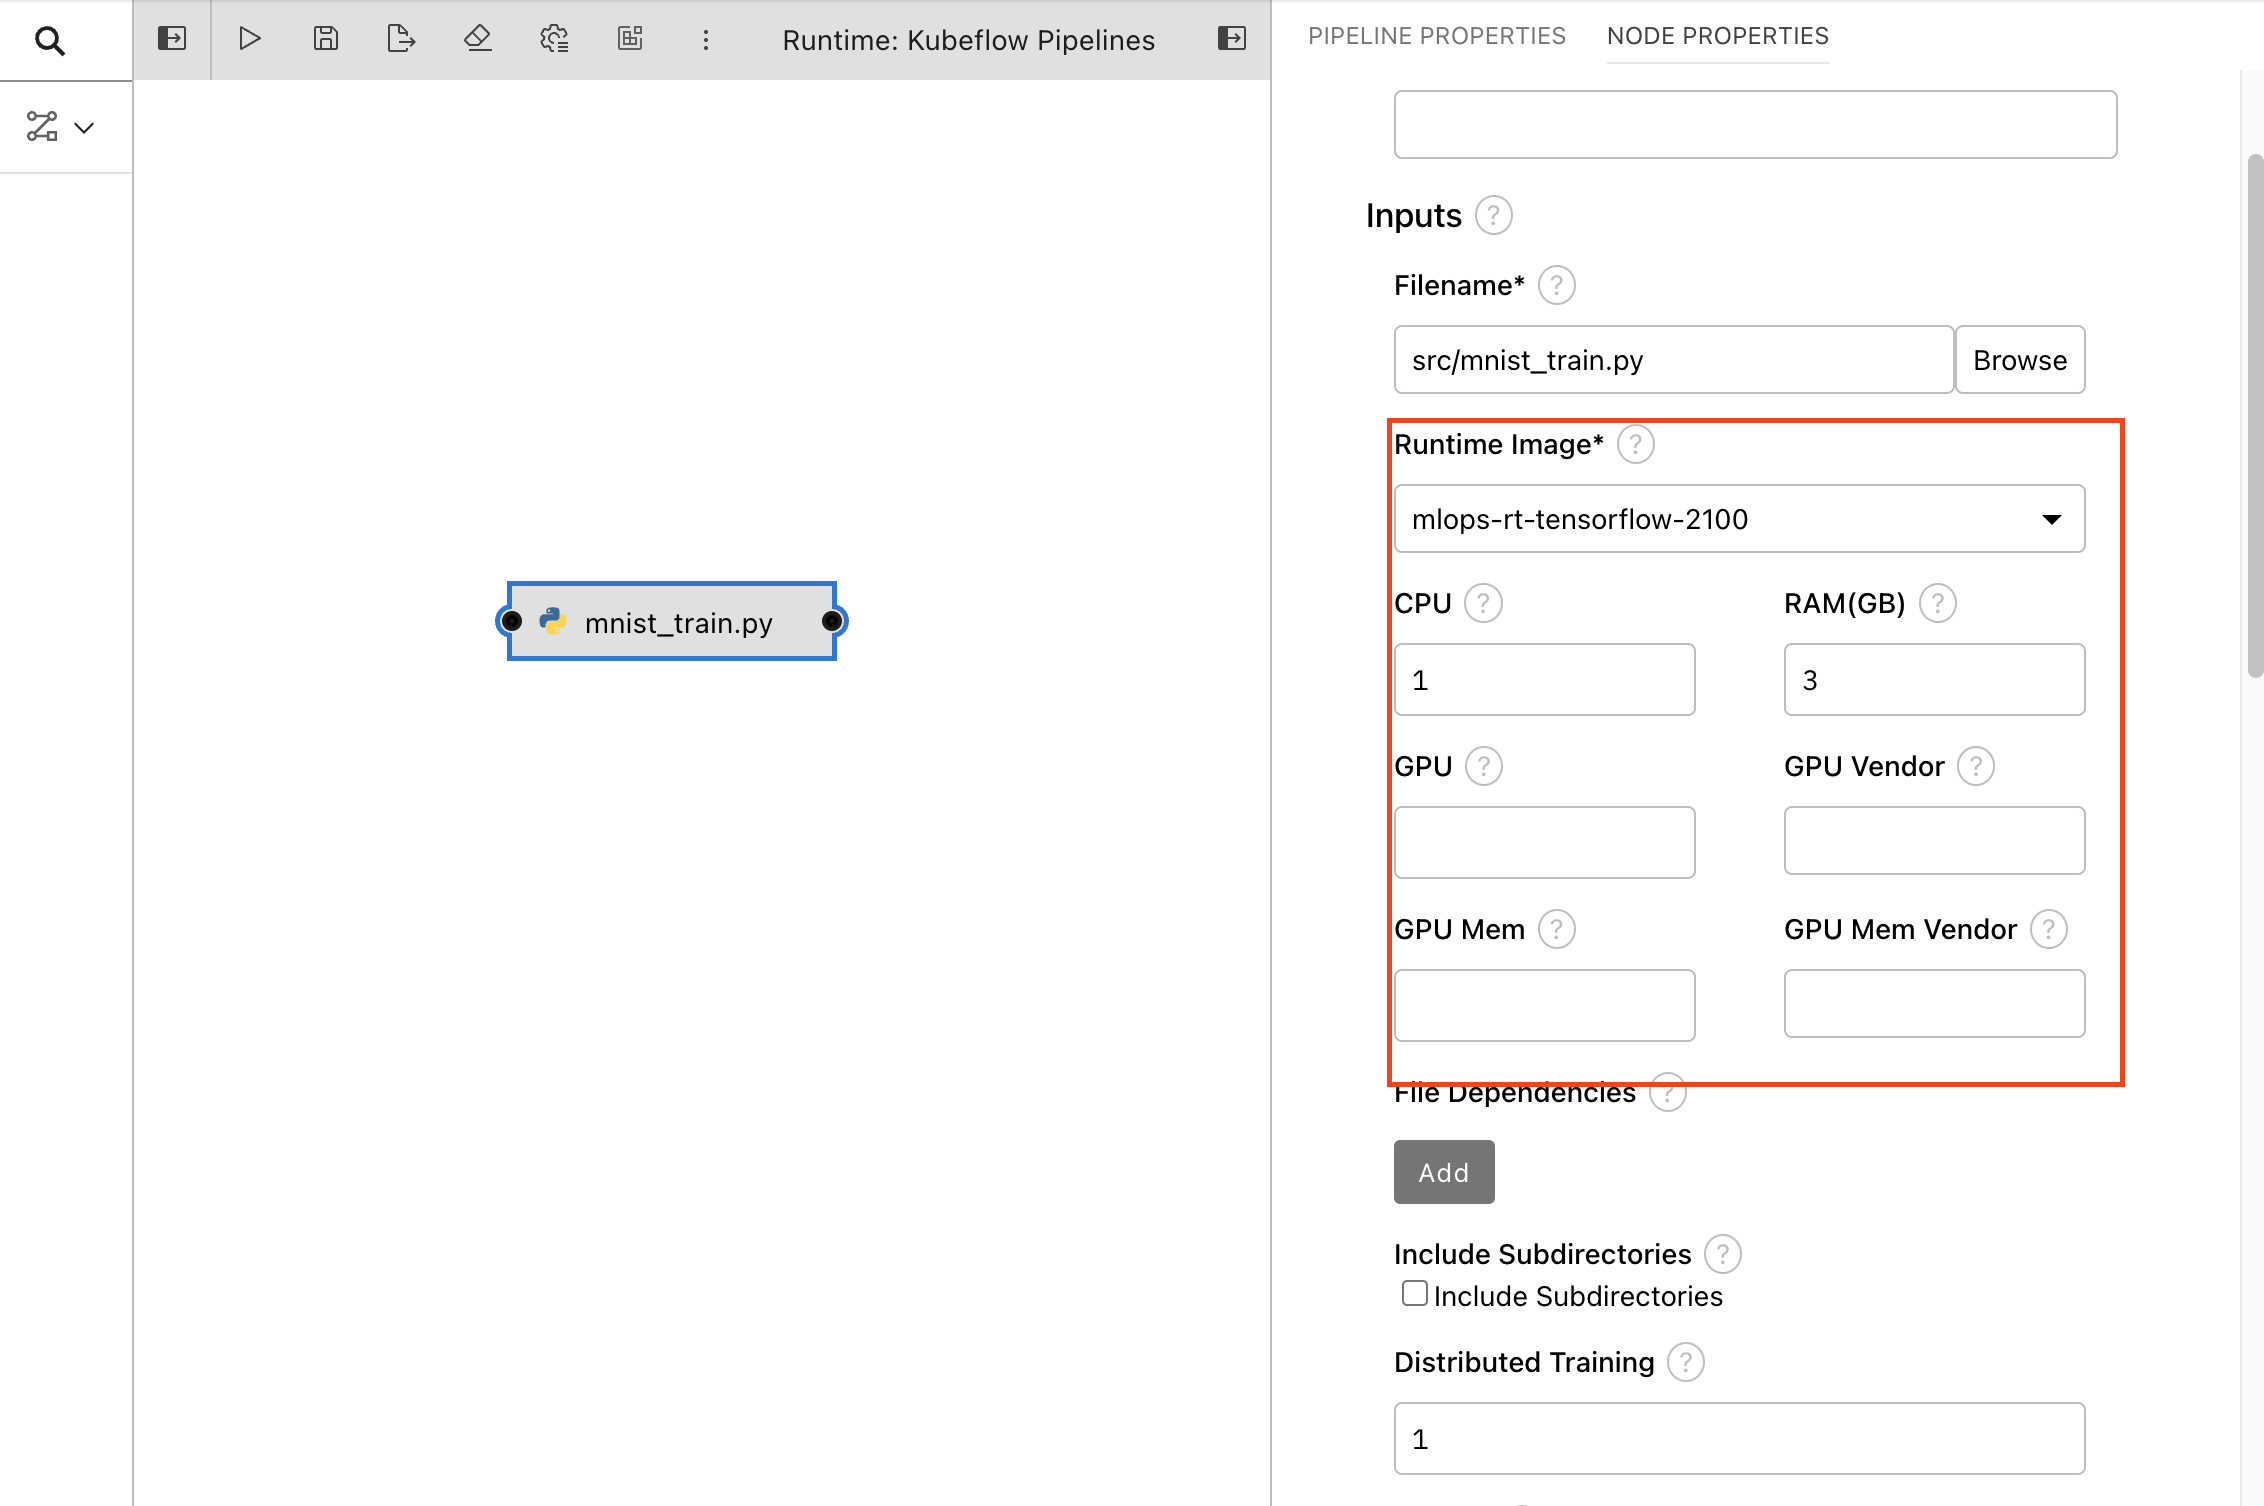
4. 点击“运行”按钮提交任务到集群环境执行：

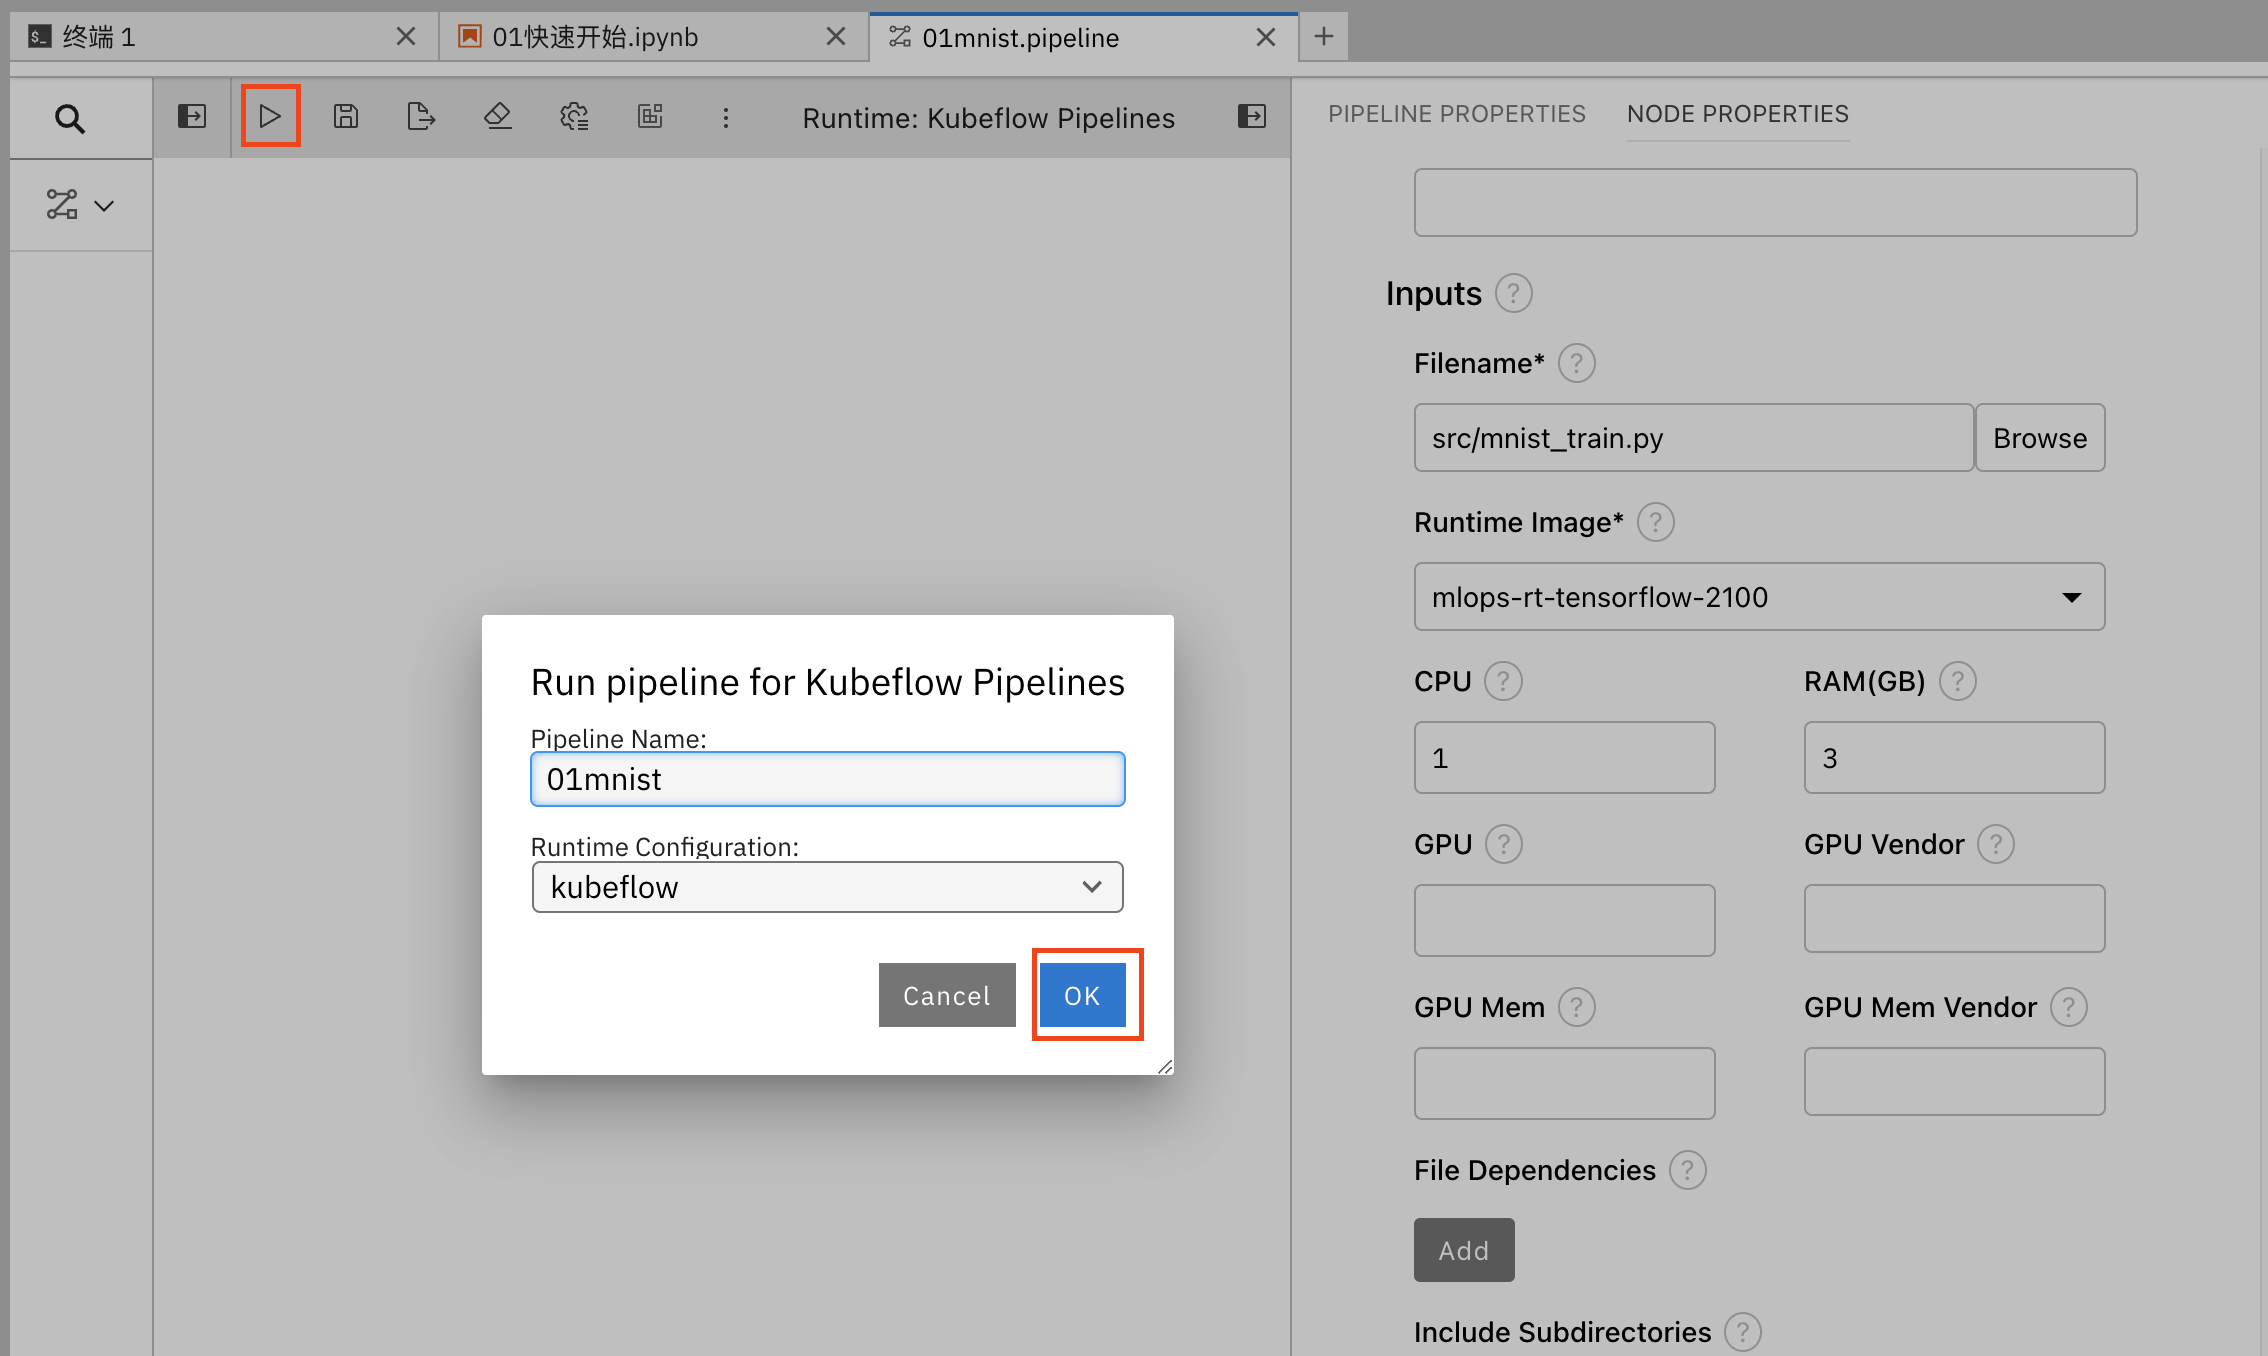


使用上述方法完成提交后，回到主界面，进入执行记录导航，即可在列表中找到到刚才提交的任务，点击对应项目即可跳转到任务执行详情页面。

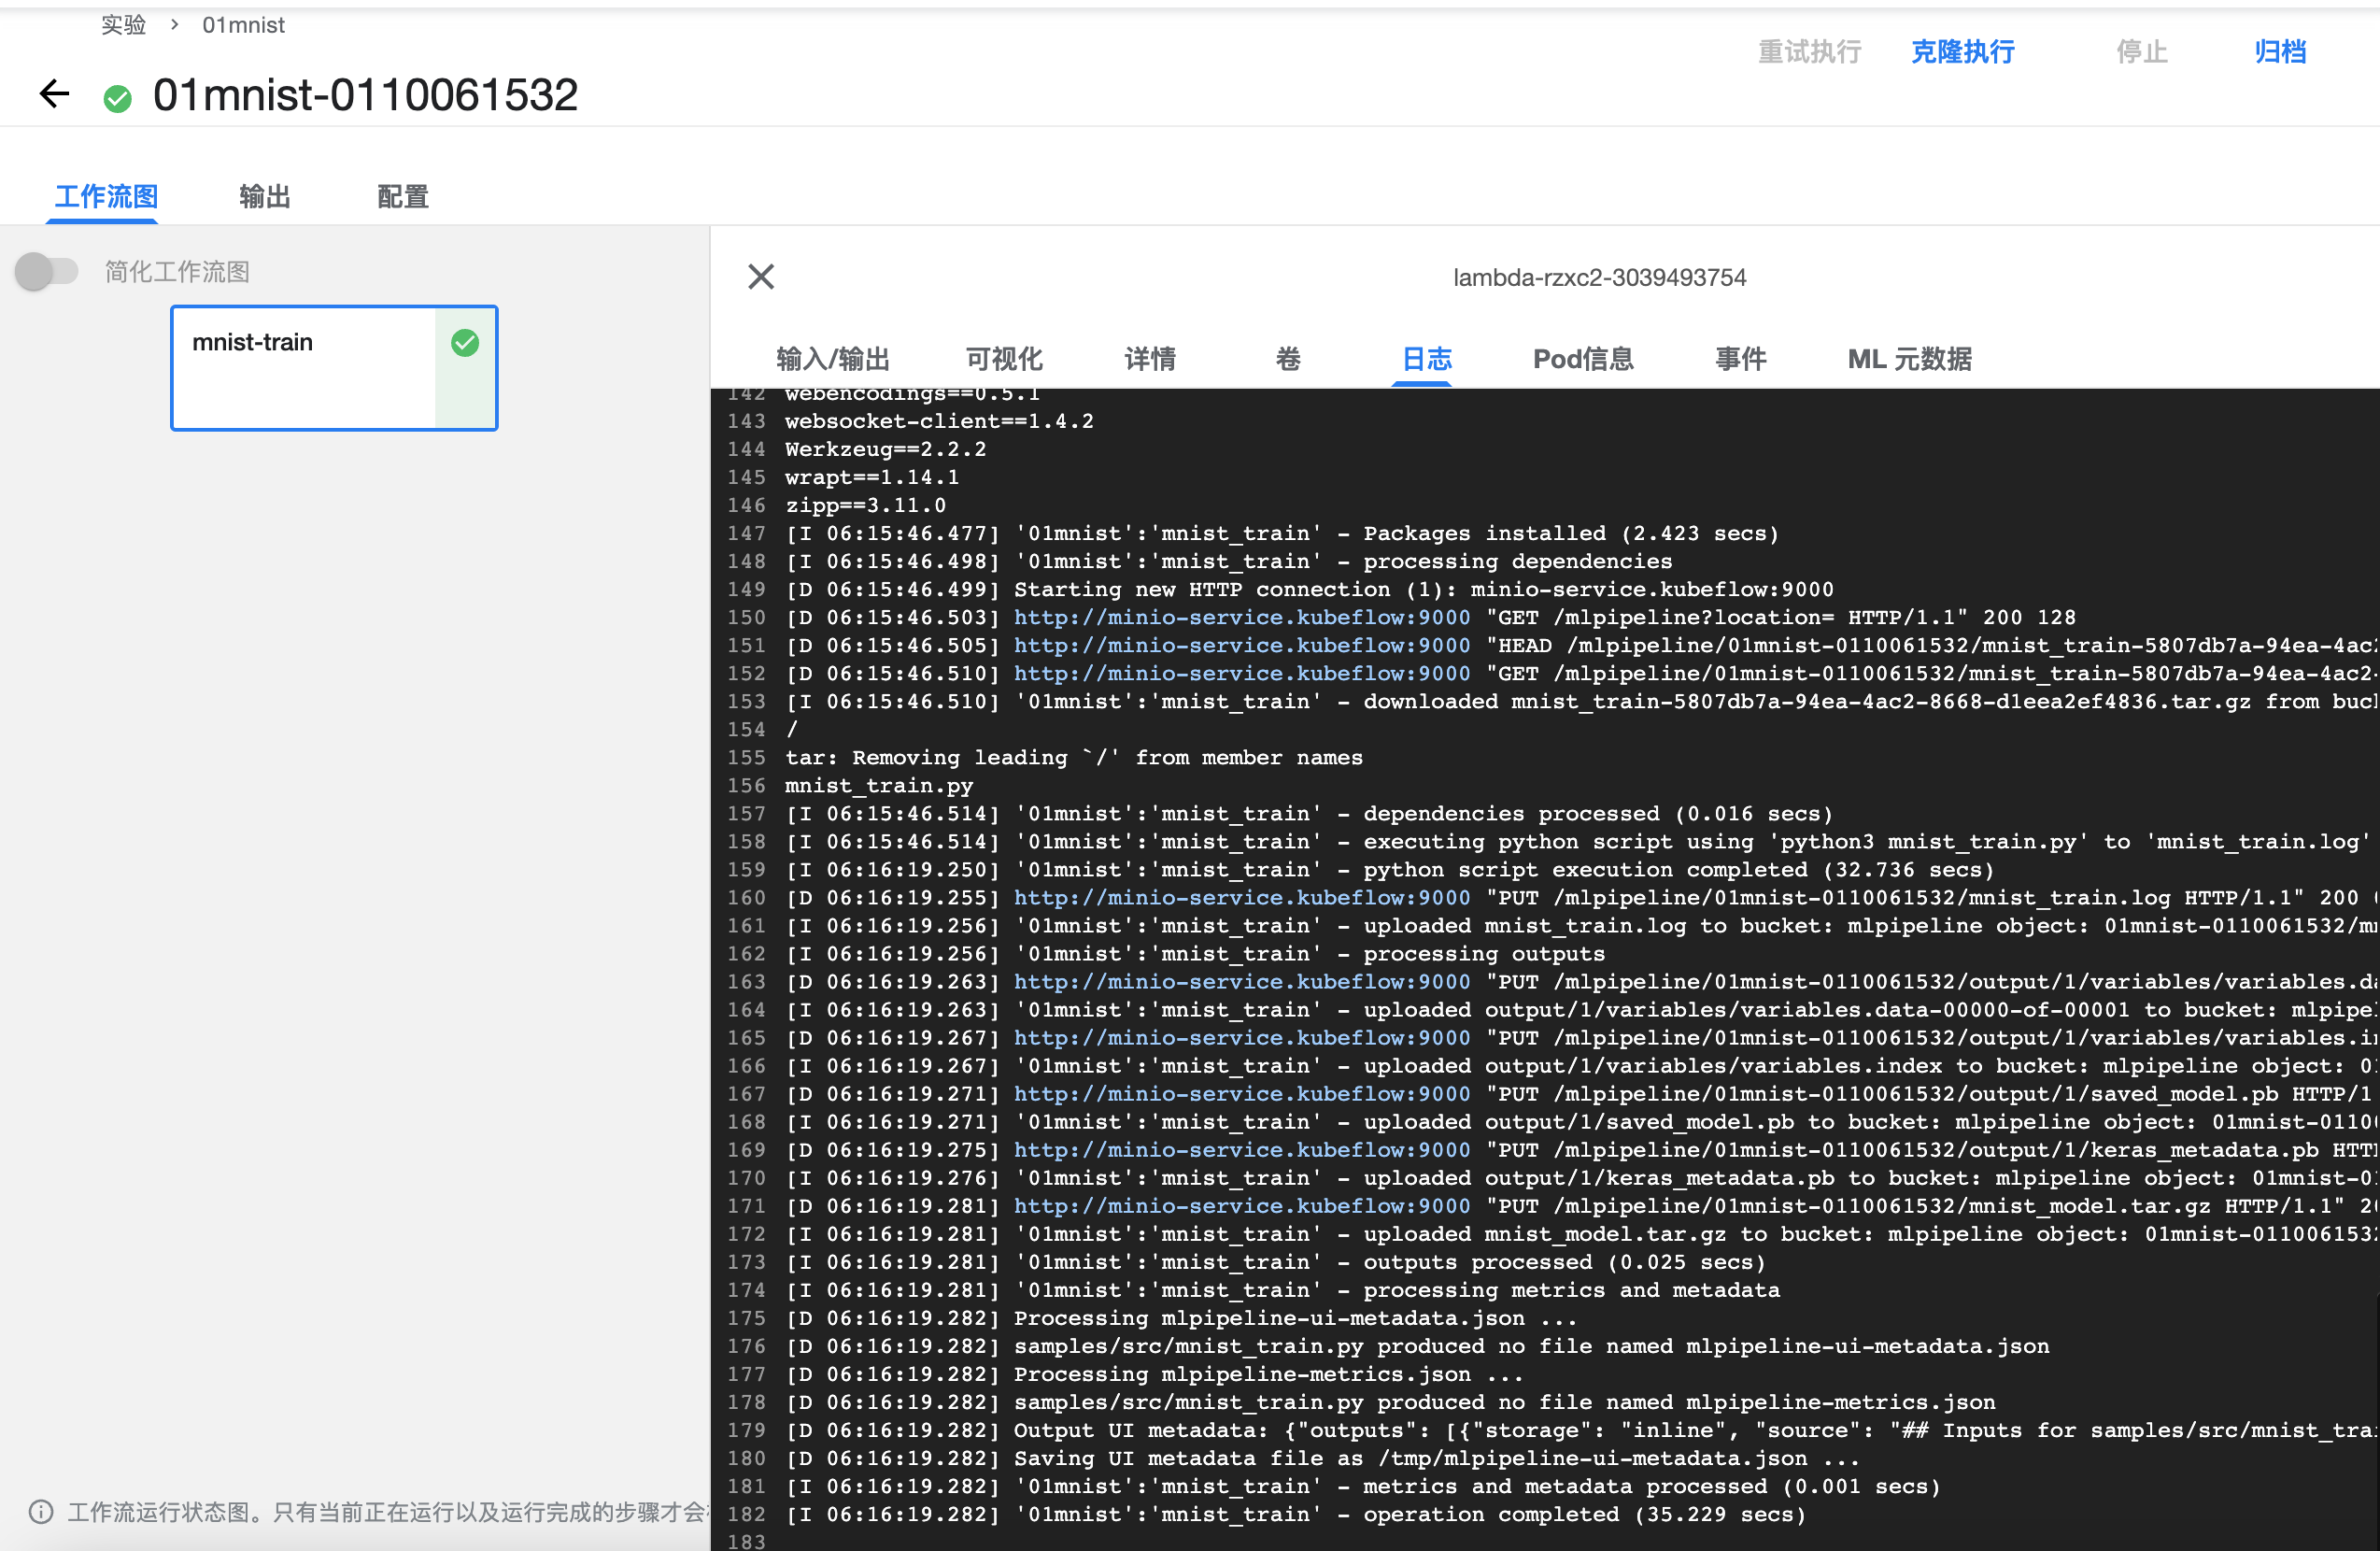

详情页面中可以查看任务每个步骤的执行状态，输入输出，总体日志等。输出的模型文件、目录、步骤详细执行日志，可以根据任务ID（任务详情页顶部标题处找到），在 Notebook 左侧 S3 浏览器中查看如下：

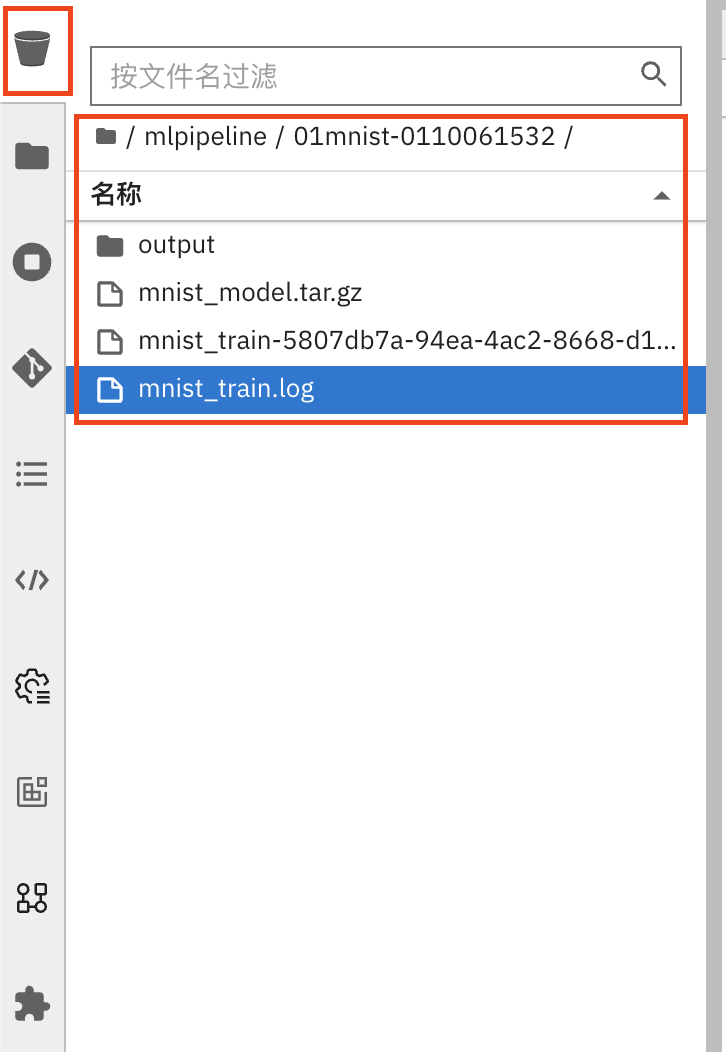

### 实验比对

我们在示例代码中已经包含简单的使用 [mlflow](https://www.mlflow.org/) 进行实验追踪的代码。在运行以上示例时就会将训练详情记录在 mlflow 服务器上。在主界面中，点击左侧导航中的“实验追踪”，即可进入 mlflow 界面，查看已经记录的实验详情：

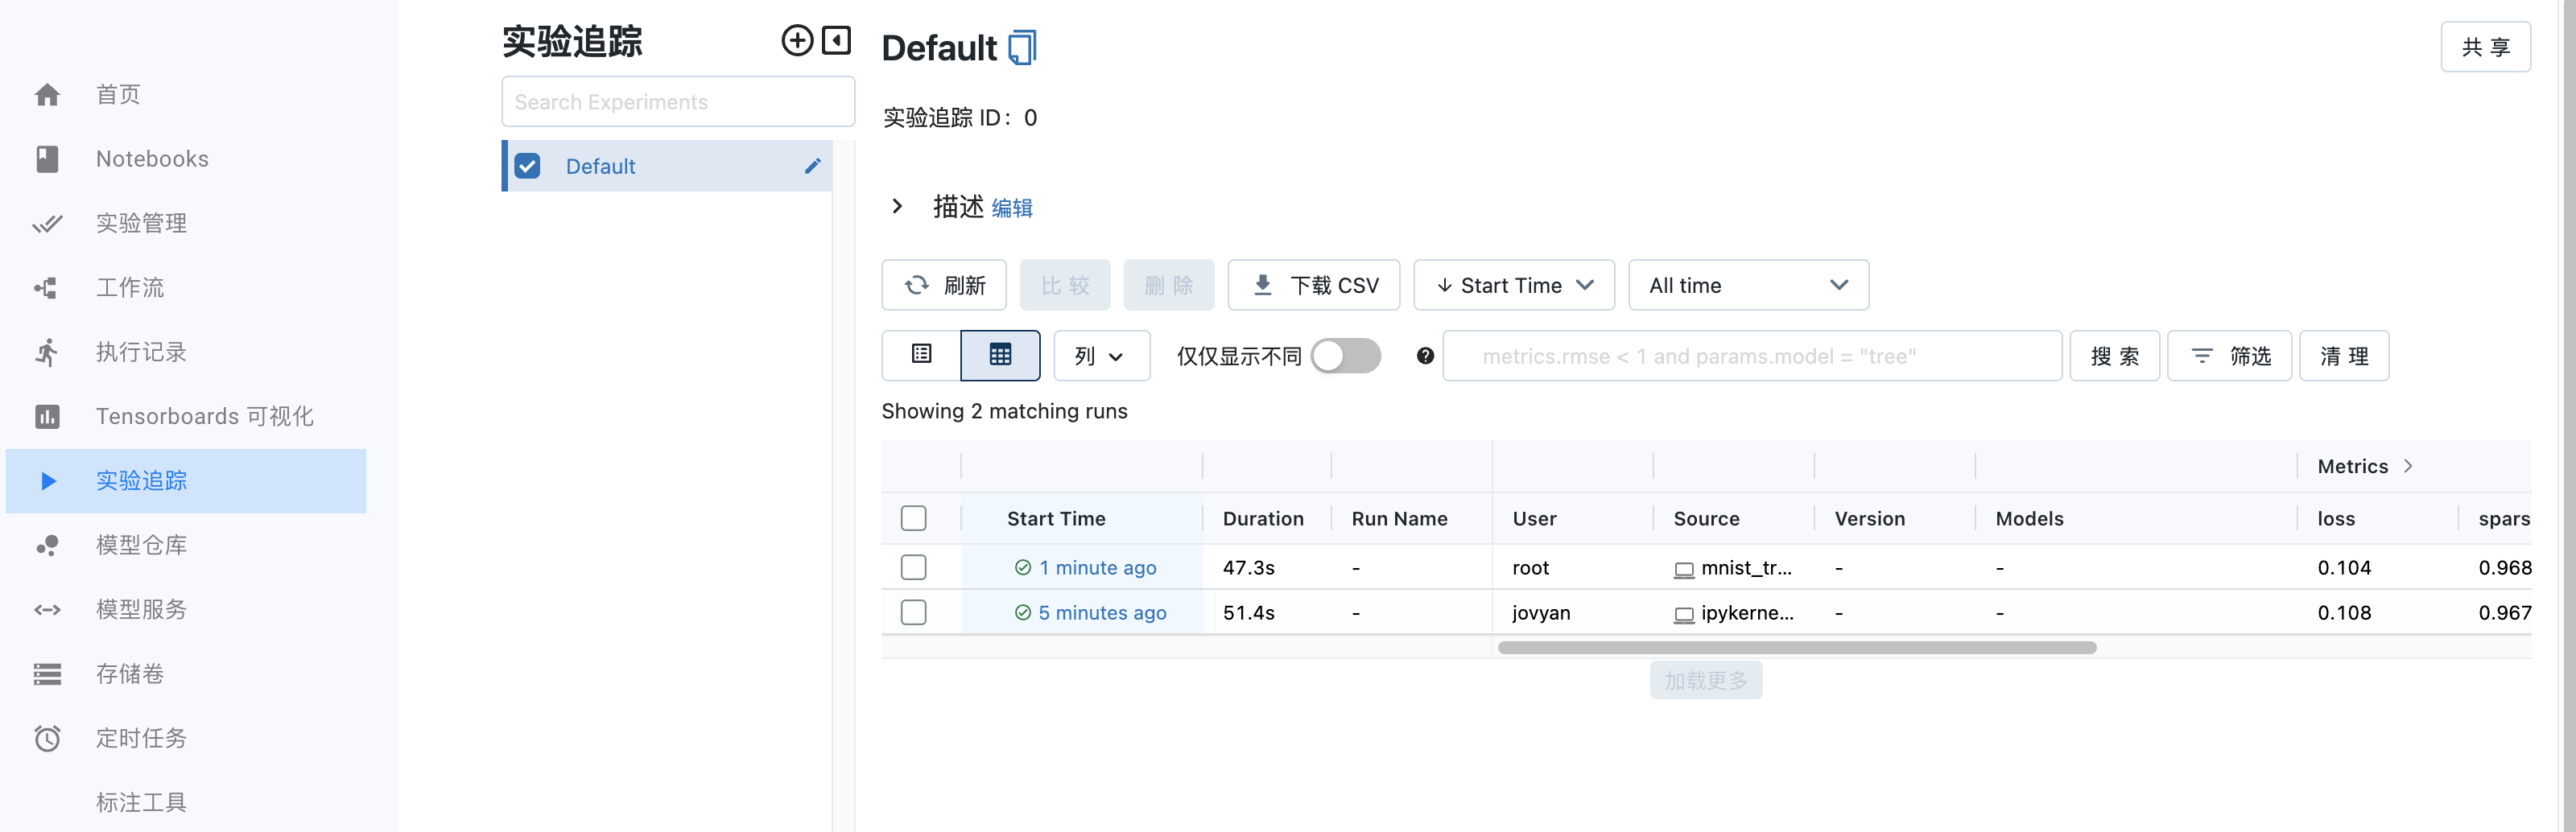

如果需要进行详细的实验比对，可以在列表中勾选需要对比的实验记录，点击“比较”按钮，可以进入详细实验比对页面：

***注意：实验对比页面、实验详情页中的图表等，需要在新浏览器标签中展示，打开如 https://<域名:端口>/mlflow/ 格式的链接，再完成如下操作即可正常展示图表。此问题是已知问题会在后续版本中修复。***

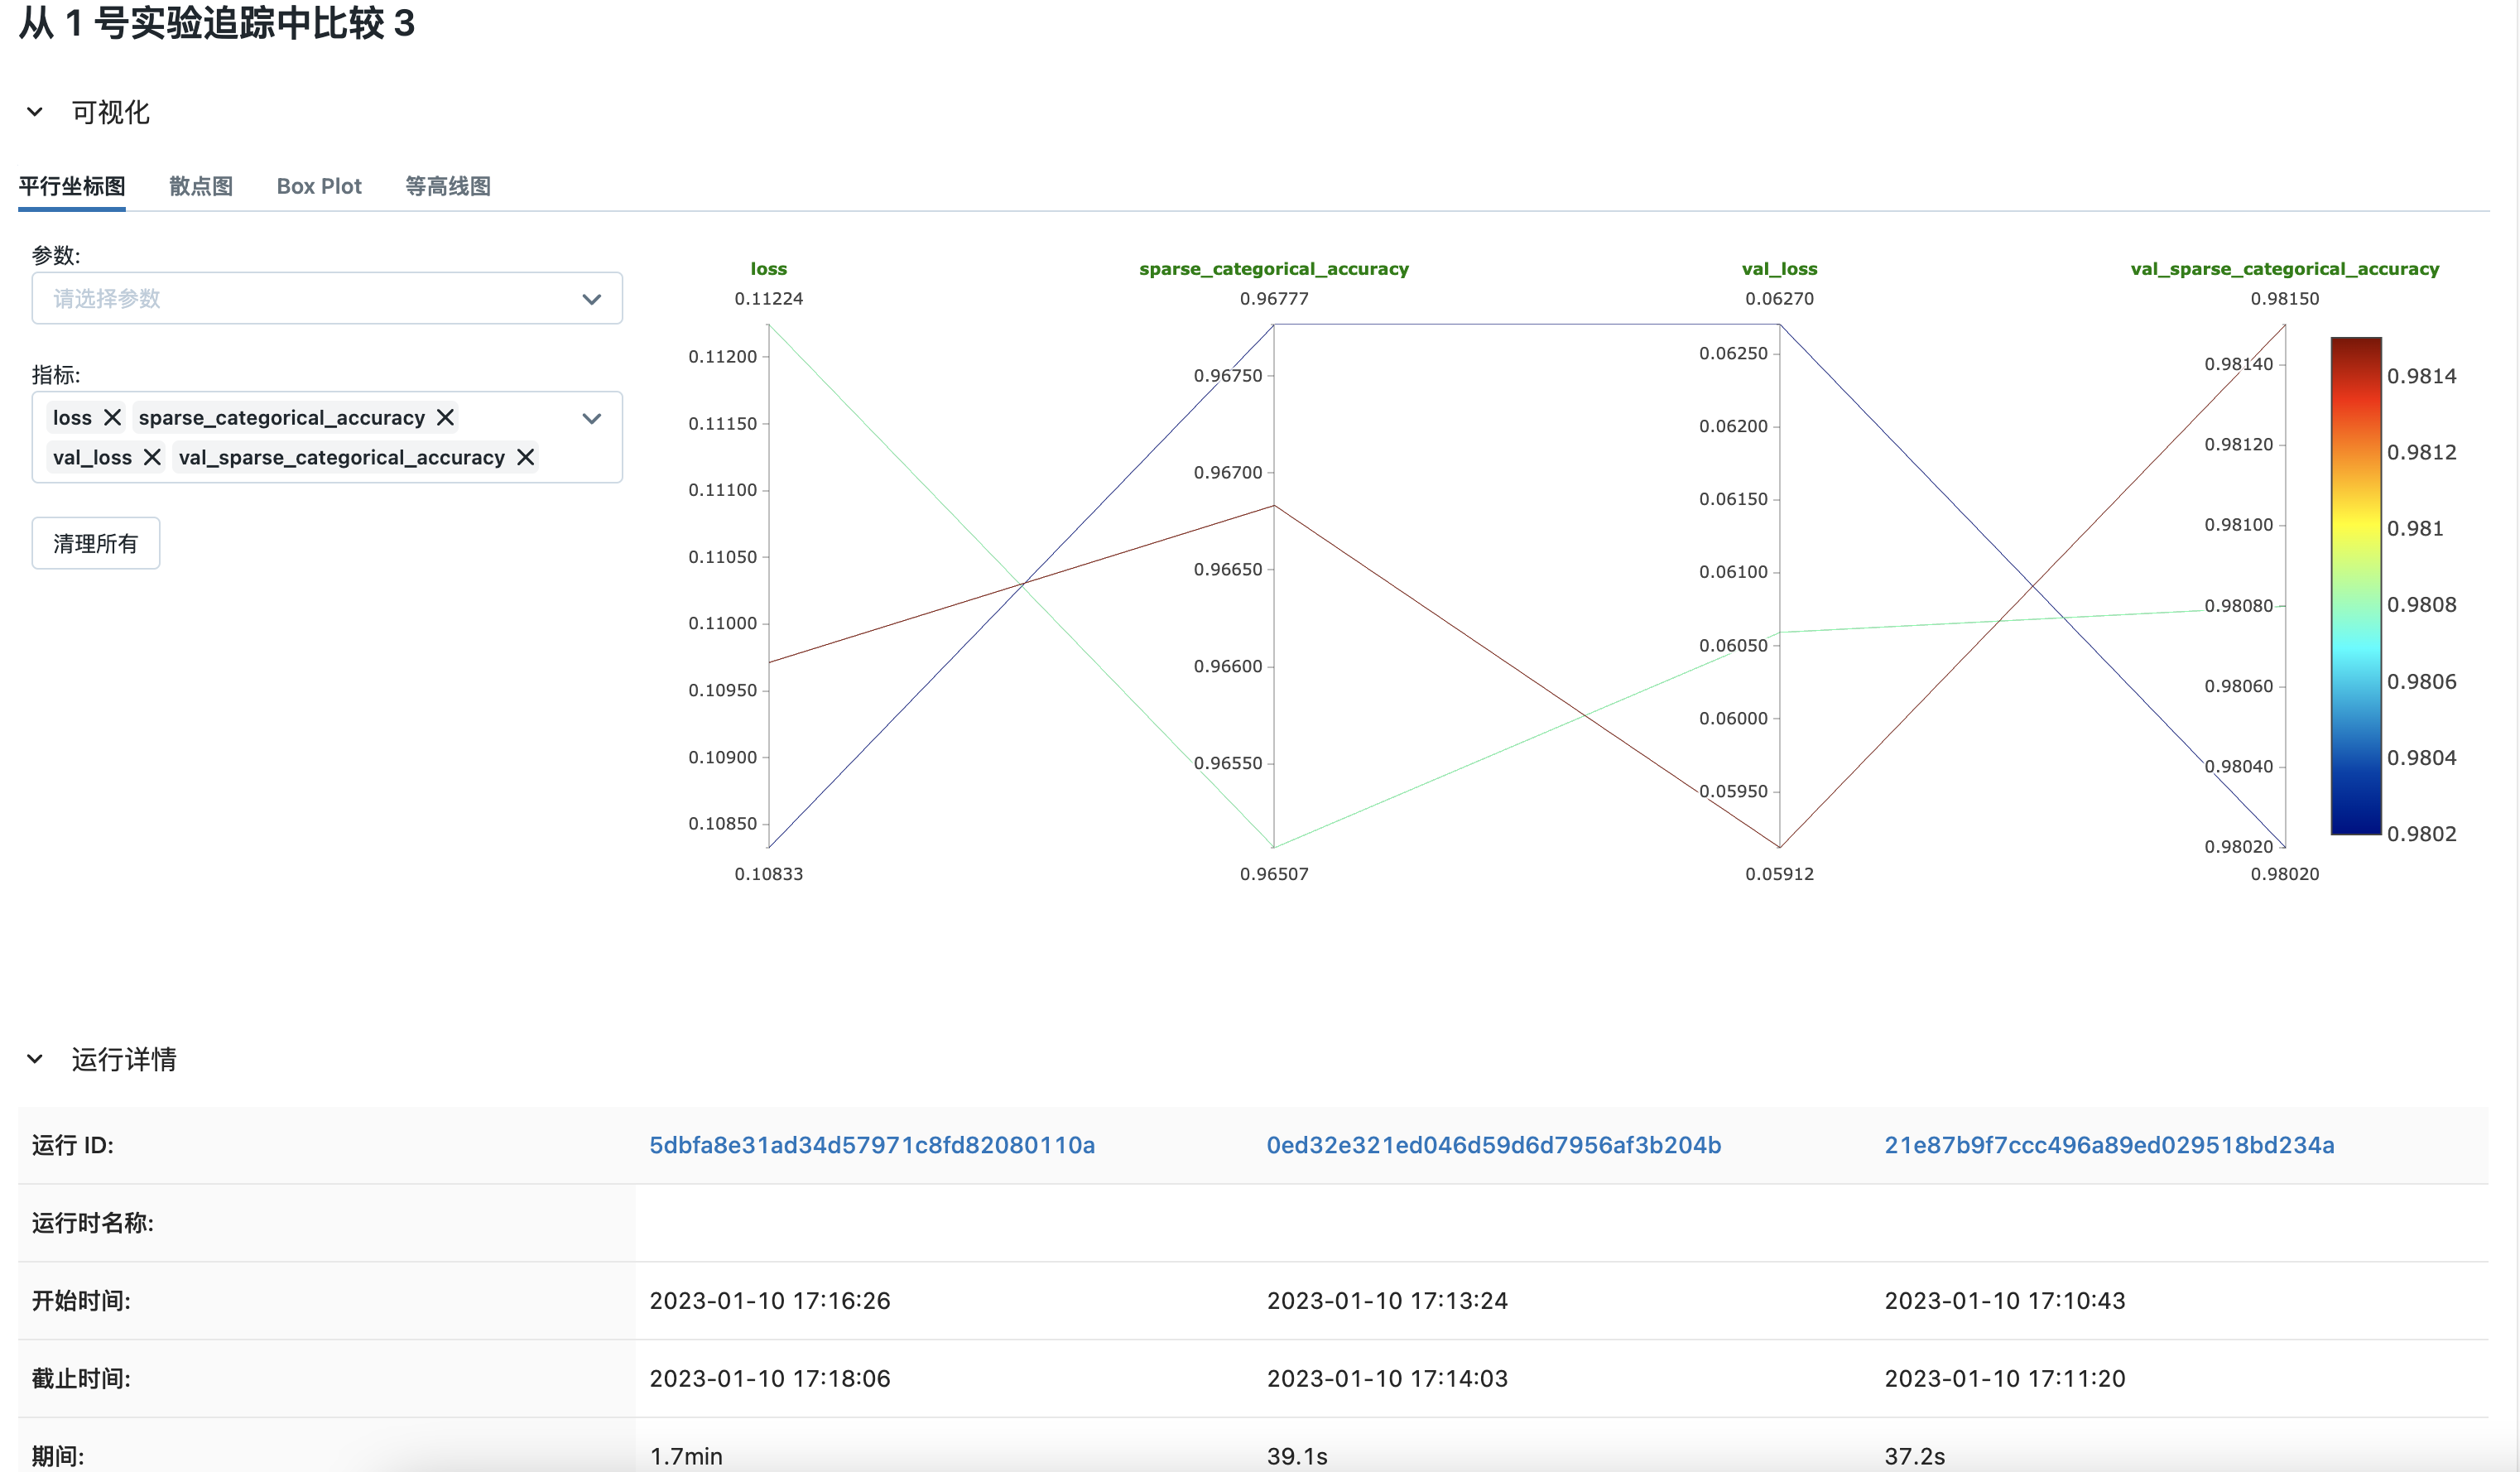

### 任务导出和定时任务

在可视化工作流编辑器中，点击工具栏中的“导出”按钮，将任务配置导出成为 yaml 文件：

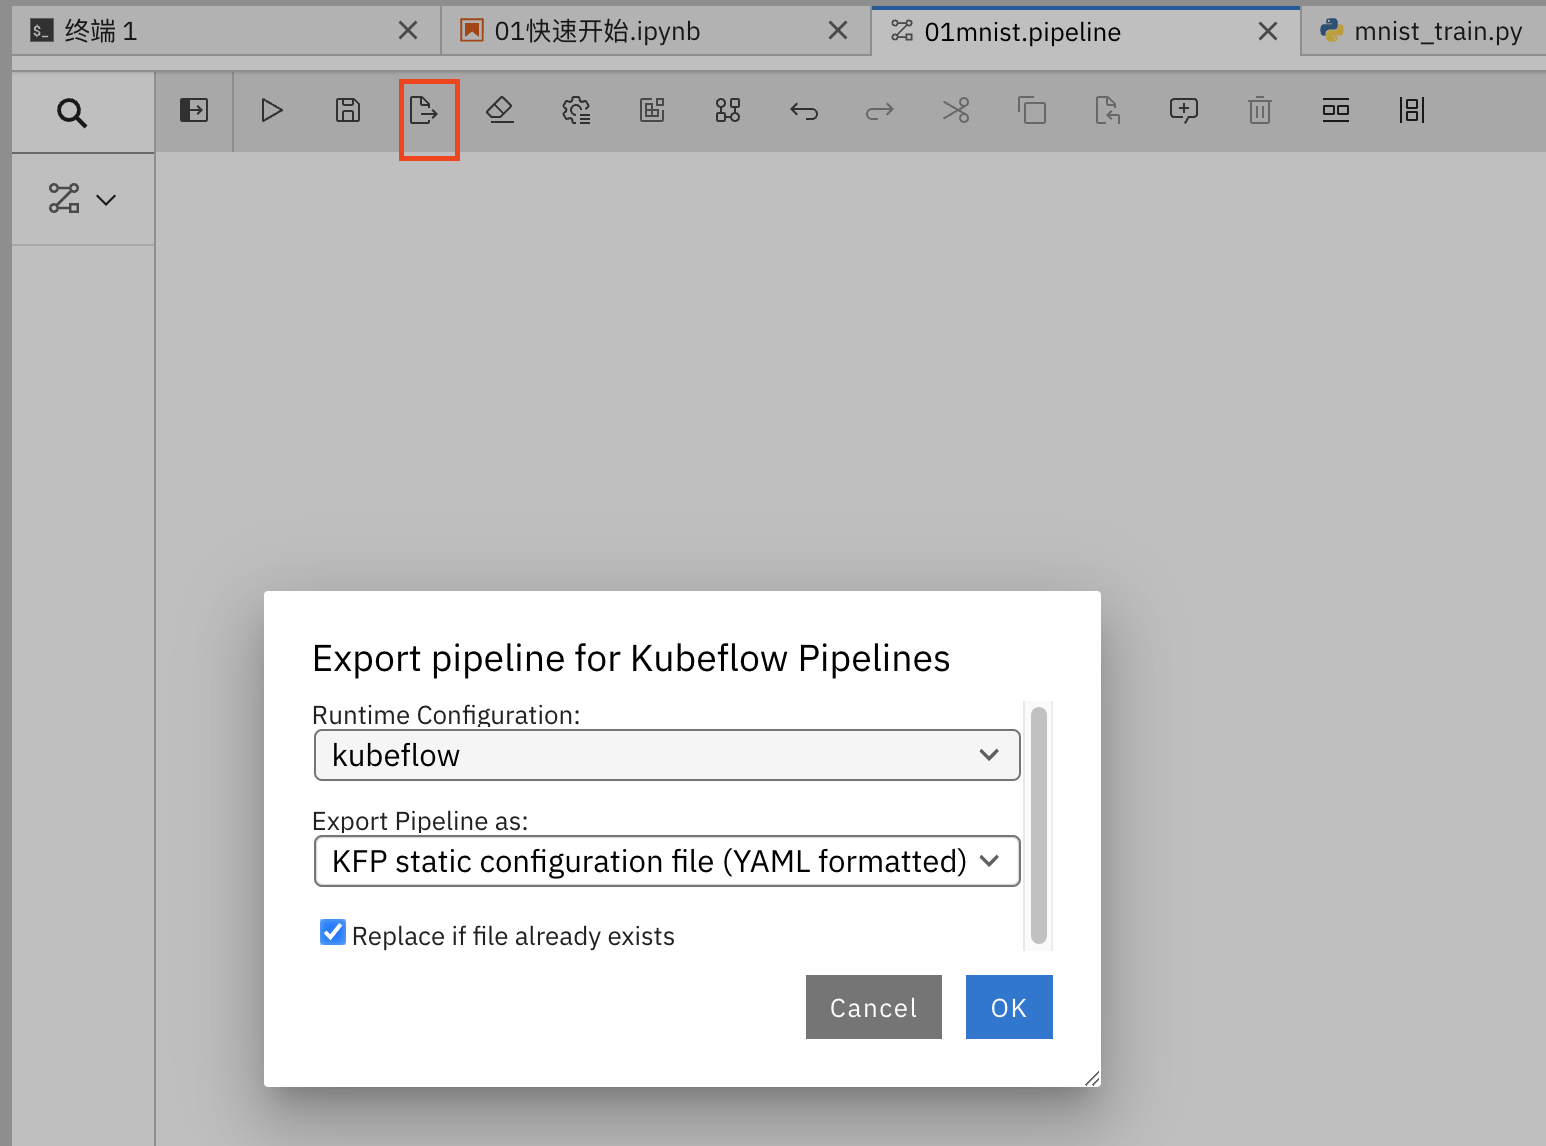

在 Notebook 界面左侧找到这个文件，右键 -> 下载到本地。然后在界面中选择 工作流 -> 上传新工作流， 并根据下图上传这个文件：

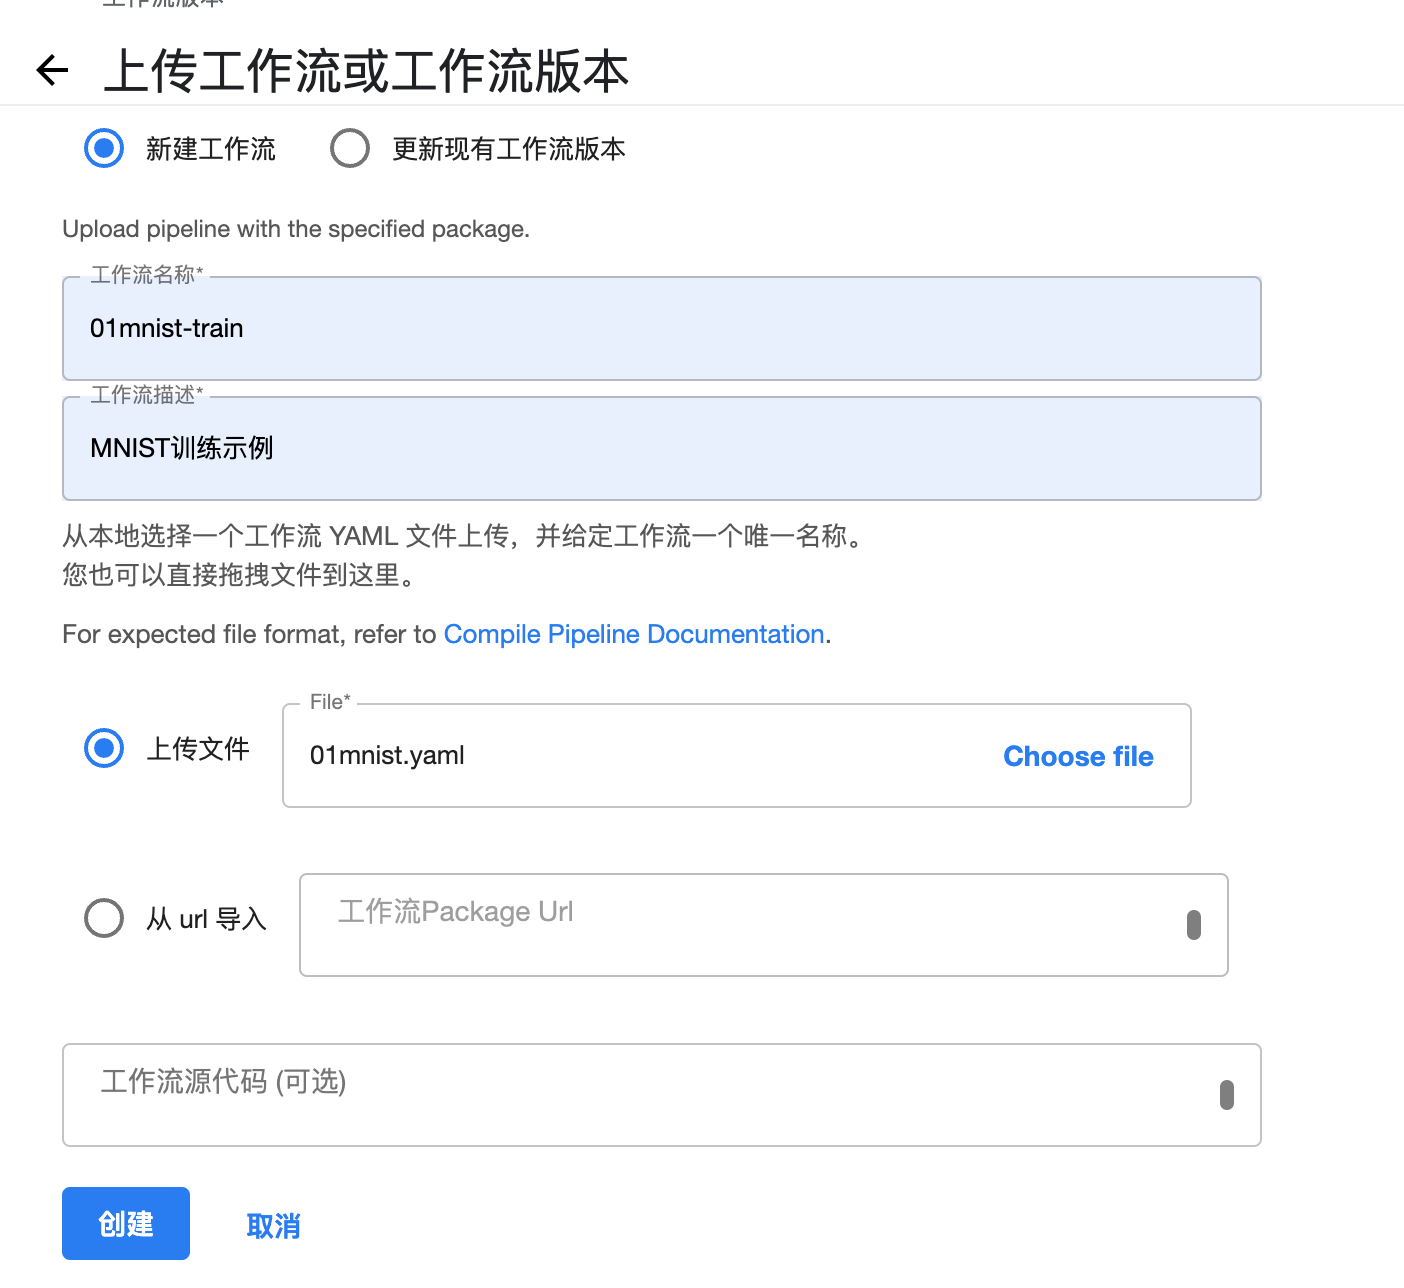

工作流创建成功后，可以看到工作流详情页面如下：

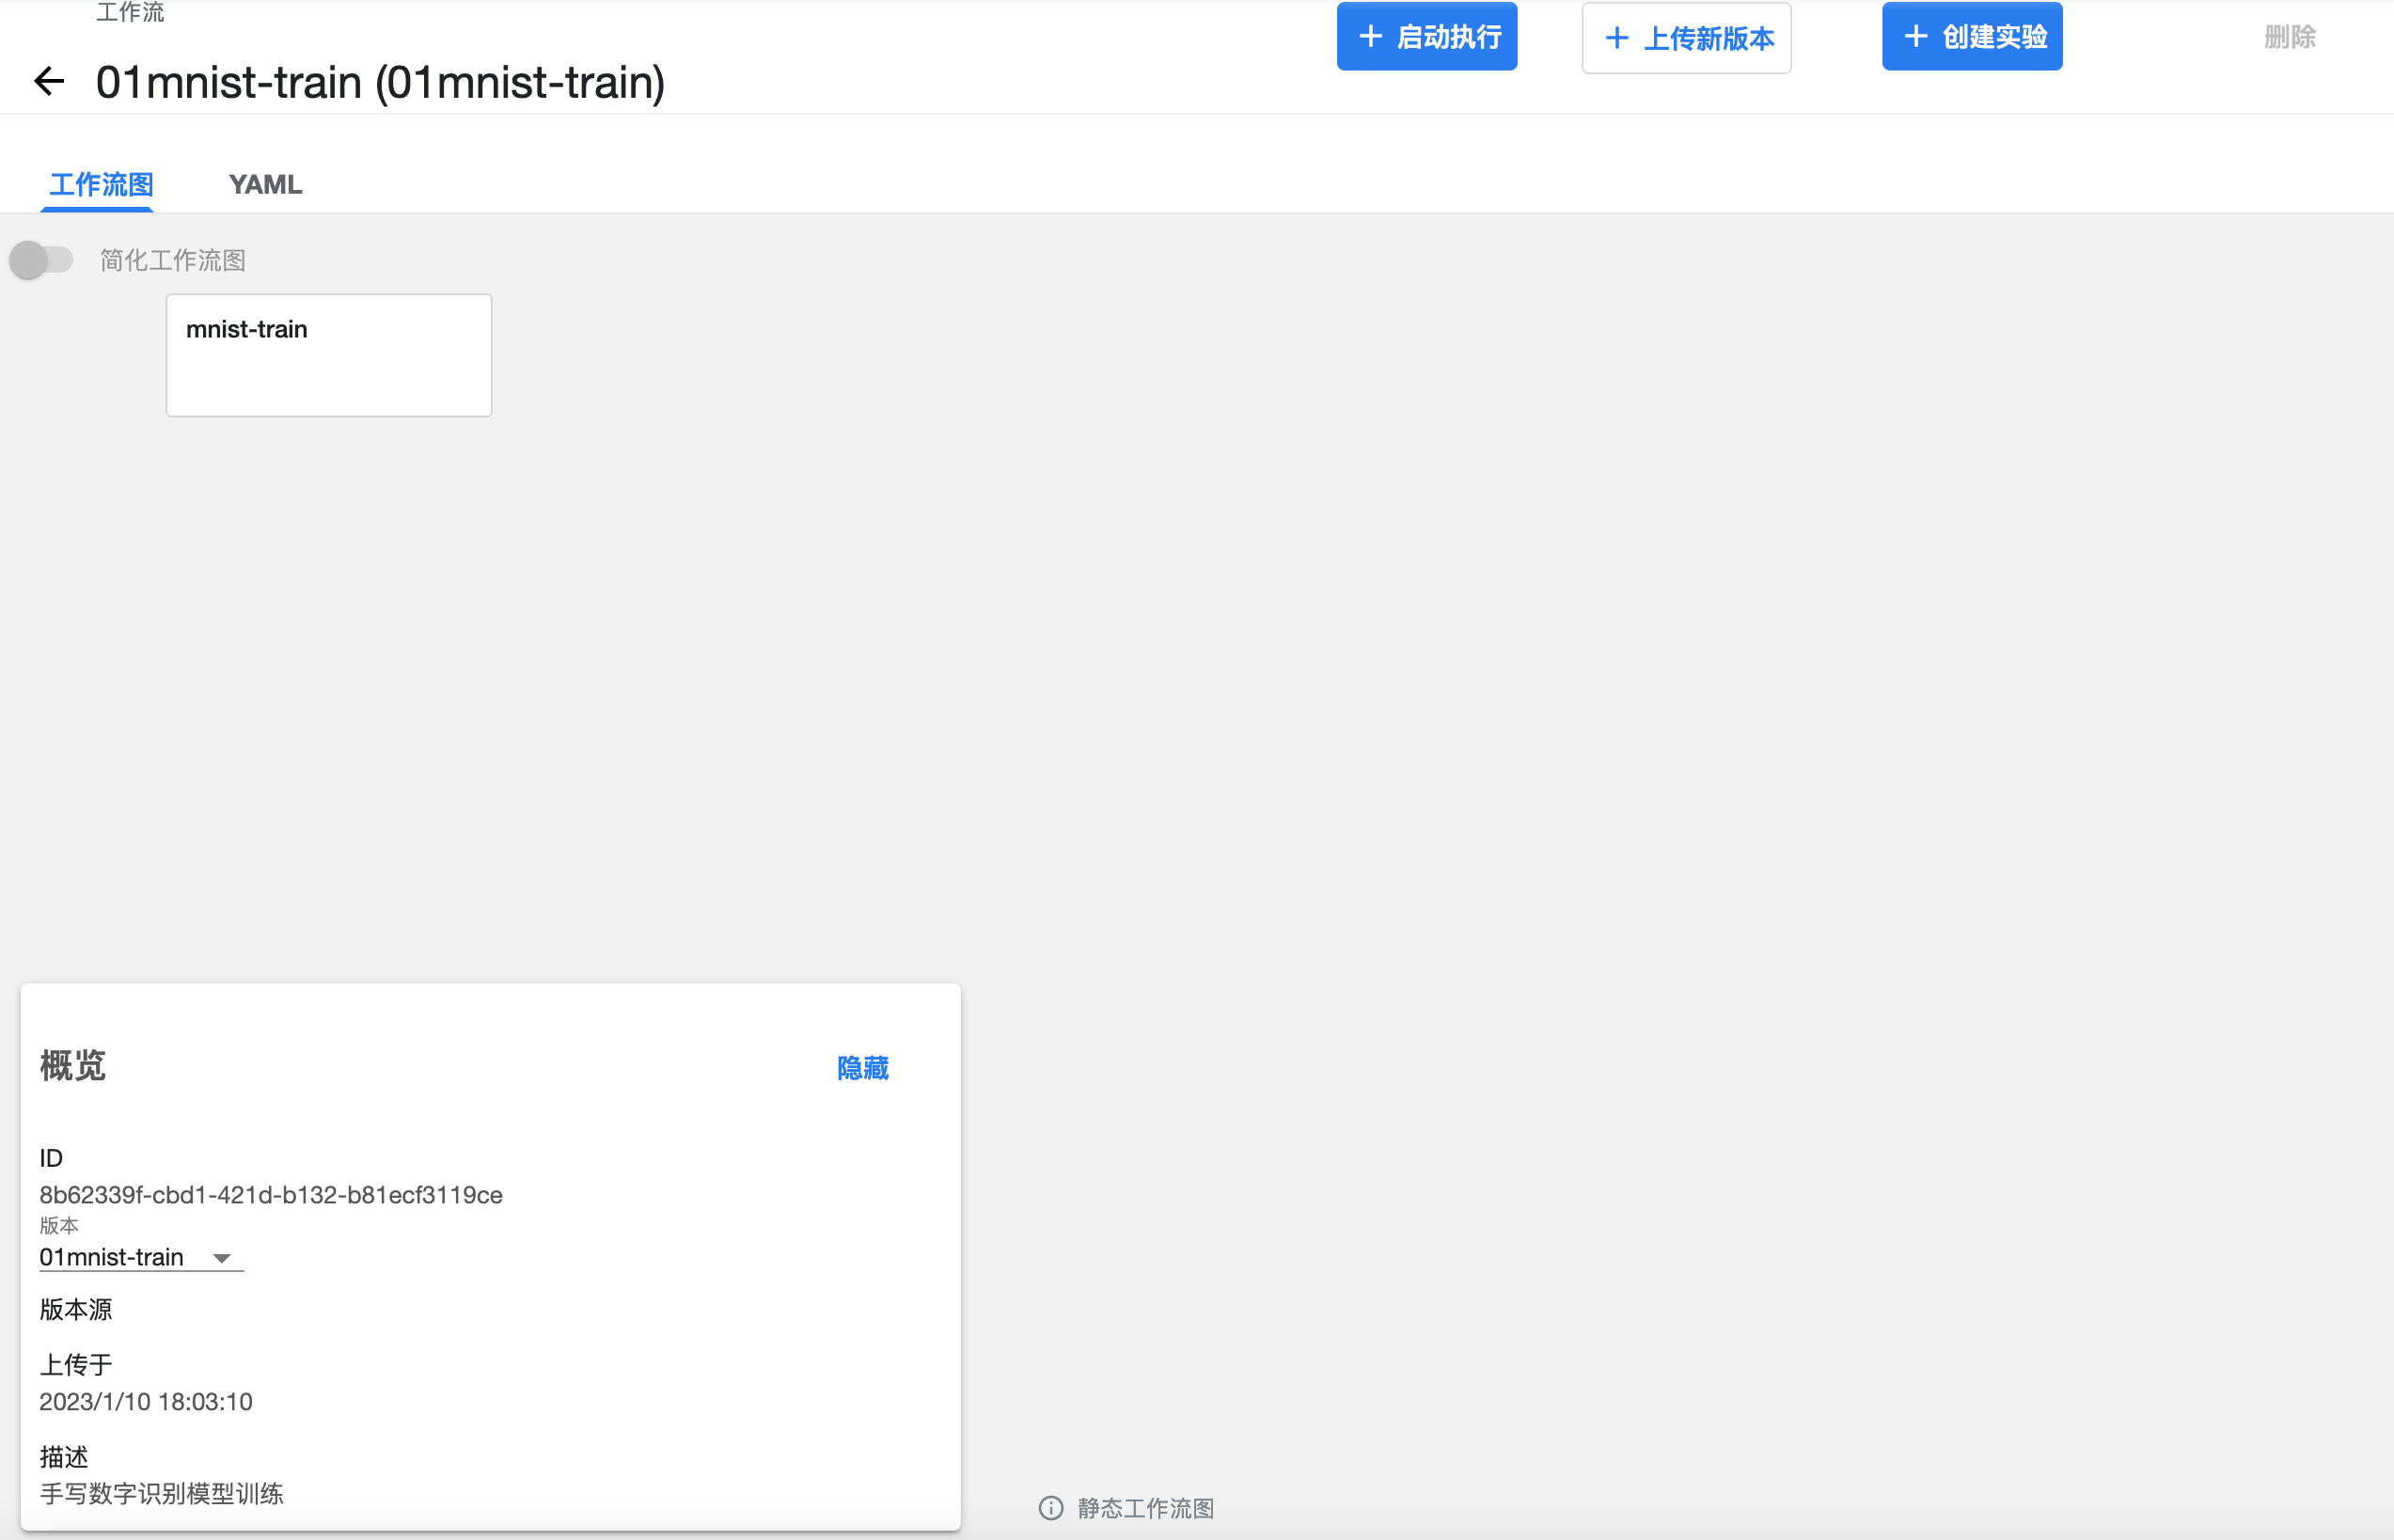

此时可以根据此工作流启动新的任务执行，或上传新的版本等操作。在启动新的任务执行时，可以选择“单次执行”或“定时任务”。如果需要配置任务为定时触发，根据提示配置合适的触发方式，设置任务定时执行。

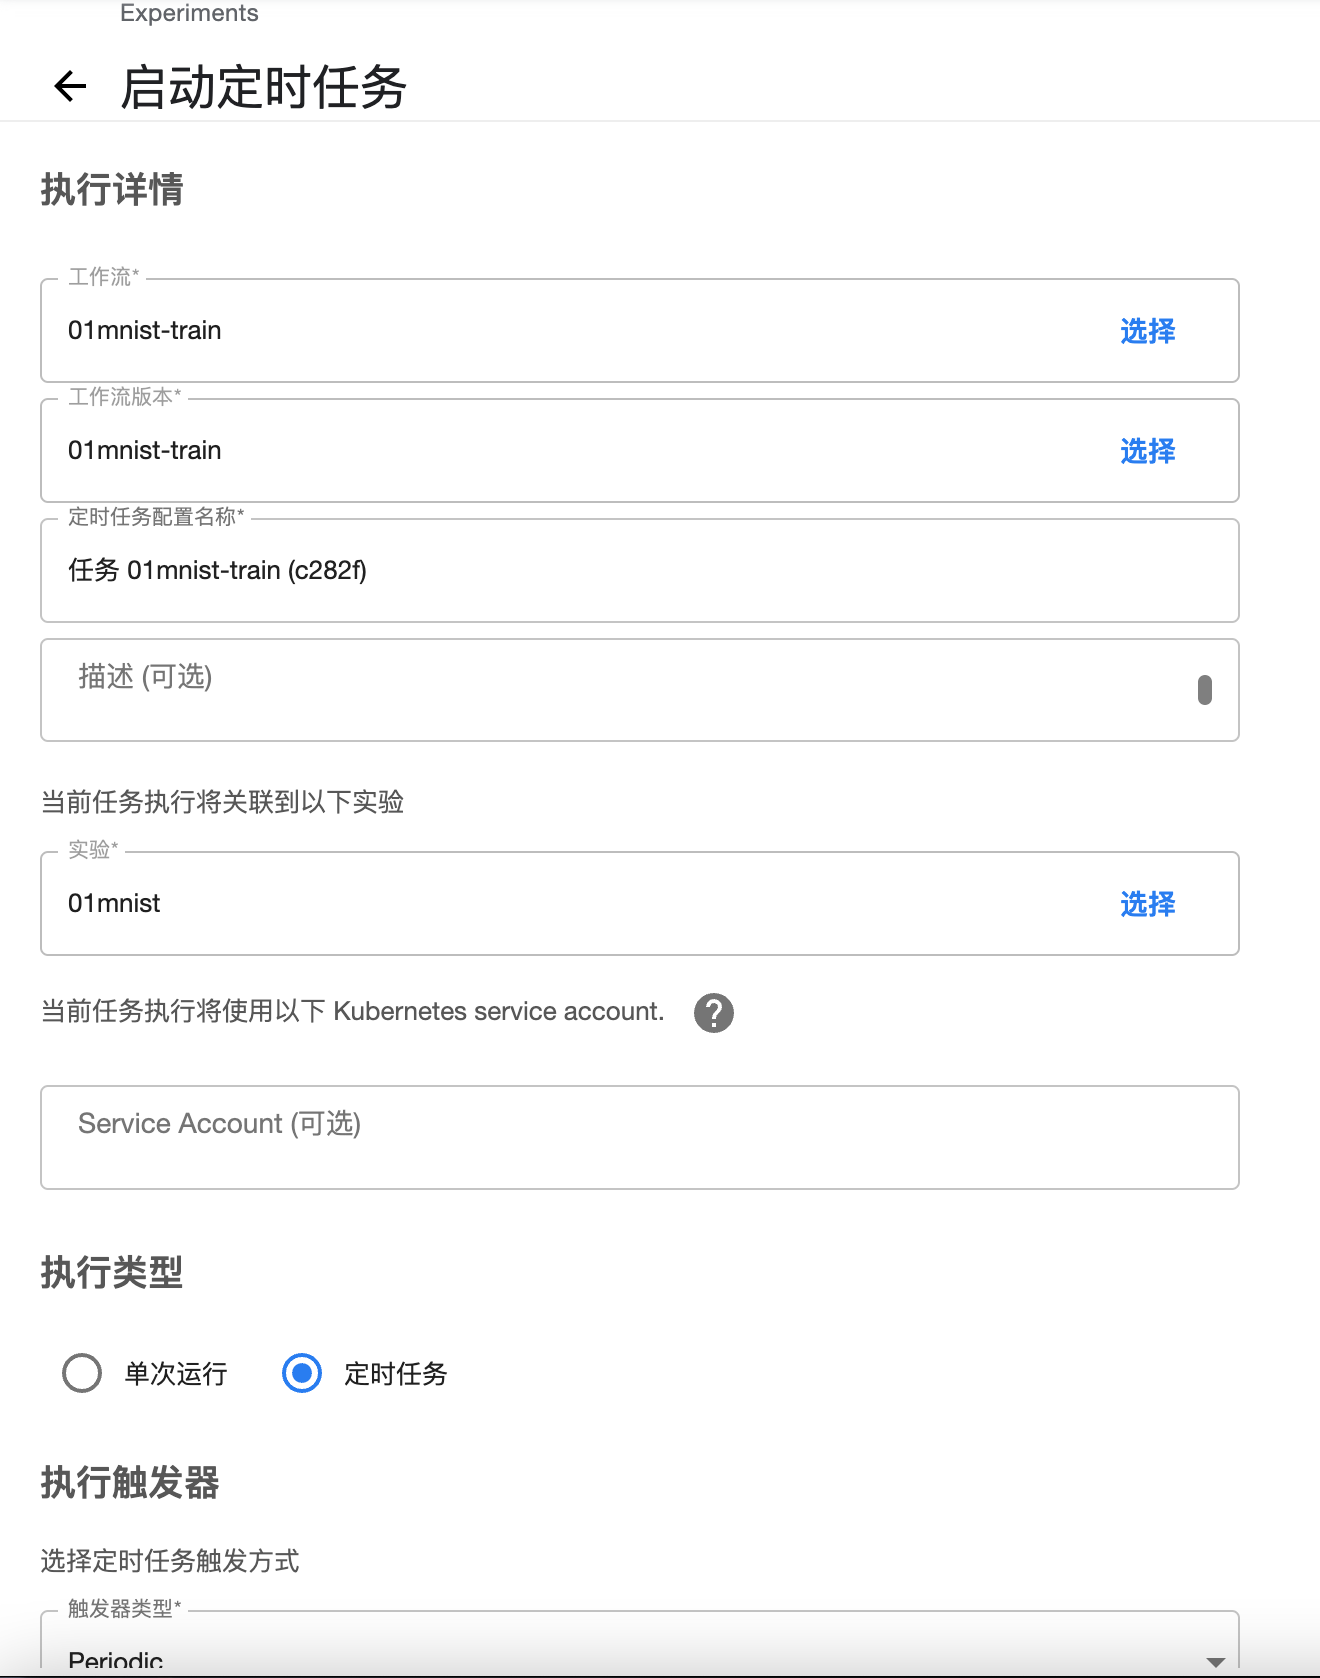

## 启动模型服务并验证

训练任务完成后，可以在界面中选择 "模型服务" -> "+ 新建模型服务" 使用之前训练输出的模型创建模型服务，在页面的输入框中填写如下 YAML 文件：

***注：在 ARM64 平台下可以使用预制运行时镜像：build-harbor.alauda.cn/3rdparty/kubeflow/tensorflow-serving:2.6.0-linux_arm64_armv8.2-a 如果需要不同架构、不同版本的运行时，也可以指定自定义镜像***

```yaml
apiVersion: "serving.kserve.io/v1beta1"
kind: "InferenceService"
metadata:
  name: "mnist-test"
  annotations:
    sidecar.istio.io/inject: "false"
spec:
  predictor:
    serviceAccountName: minio-s3-sa
    tensorflow:
      # 如果希望使用不同的 tensorflow-serving 镜像，可以指定下面配置：
      # 如果希望使用 arm64 版本 serving 镜像，可以使用：build-harbor.alauda.cn/3rdparty/kubeflow/tensorflow-serving:2.6.0-linux_arm64_armv8.2-a
      # image: <tensorflow-serving的镜像和版本>
      storageUri: "<....复制模型地址，格式为 s3://bucket/path/to/model>"
```

训练任务输出的模型的地址可以在 Notebook 左侧 S3 浏览器中根据任务ID找到：

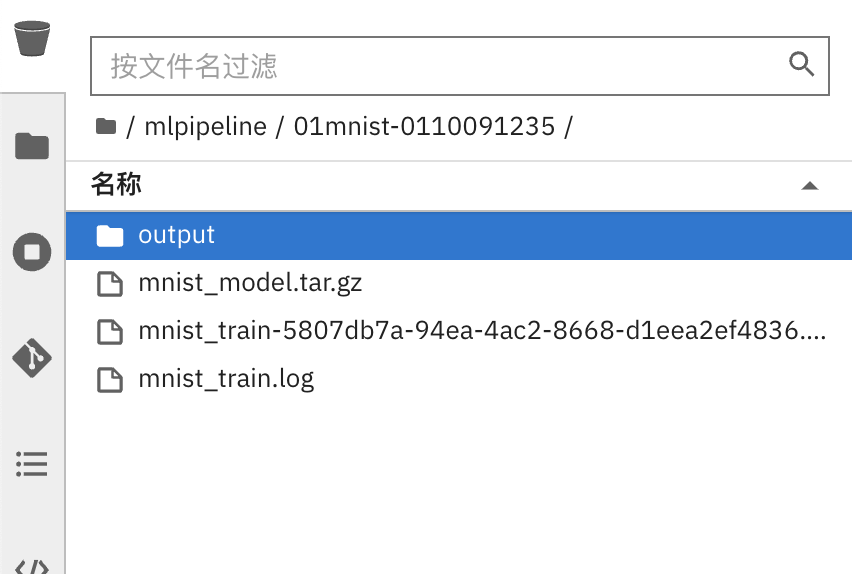

如上图，`output` 目录则是输出模型的文件夹，右键点击这个目录，选择“复制路径”，可以得到路径：`S3:mlpipeline/01mnist-0110091235/output`
然后修改成格式：`s3://mlpipeline/01mnist-0110091235/output` 填写如上述服务配置

其中 `serviceAccountName: minio-s3-sa` 是为了使模型服务能安全的访问 Minio 存储的密钥资源。默认用户在 MLOps 平台部署时已经部署，如果需要为新增的用户增加访问权限，请联系管理员完成配置。配置完成后，点击 "创建" 按钮并等待模型服务启动成功：

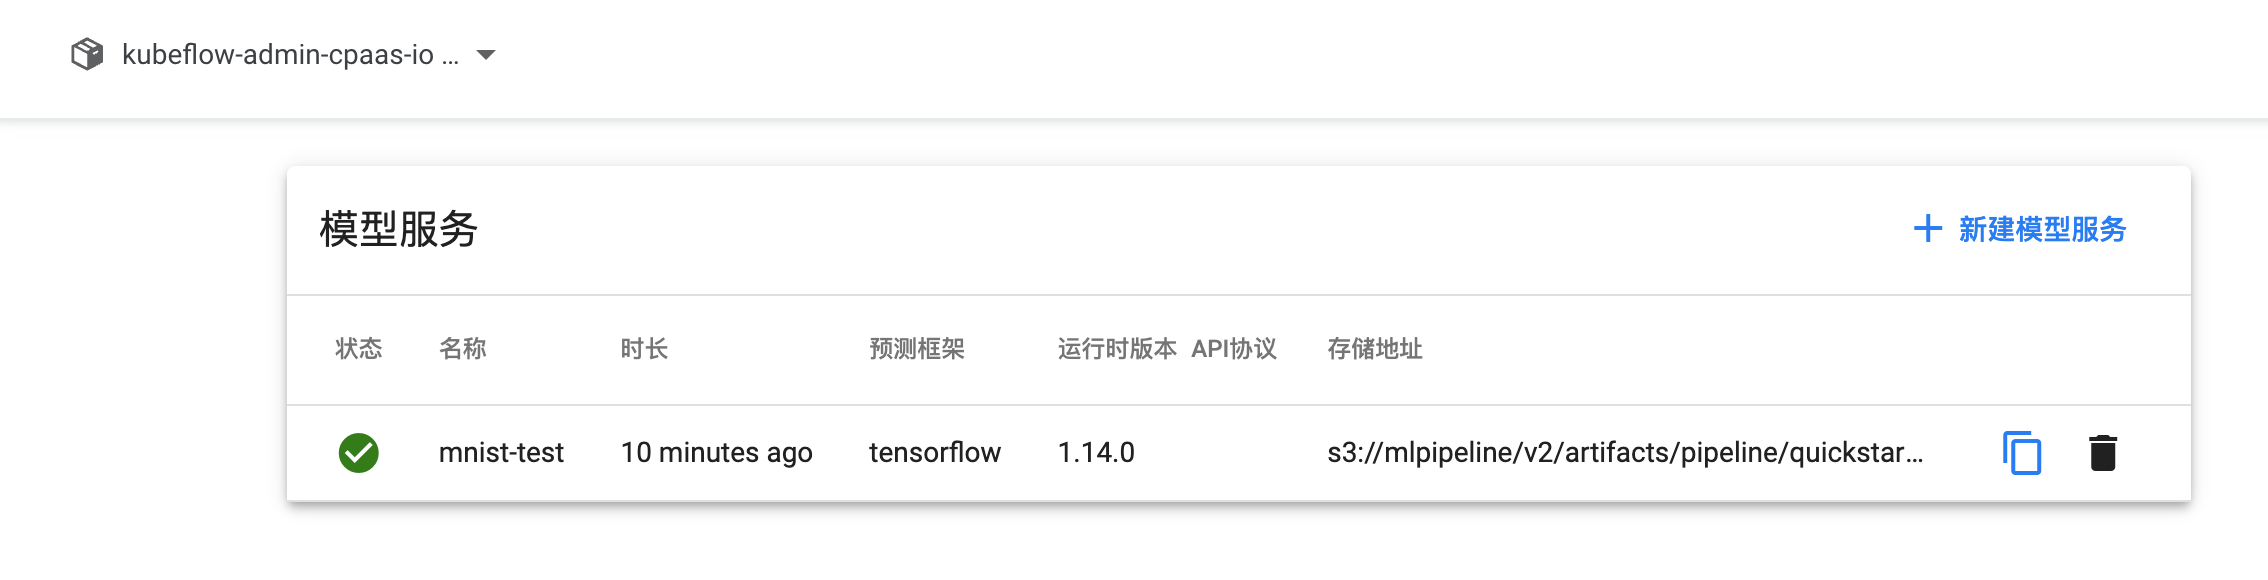

点击模型服务名称，即可查看模型服务的详细信息：

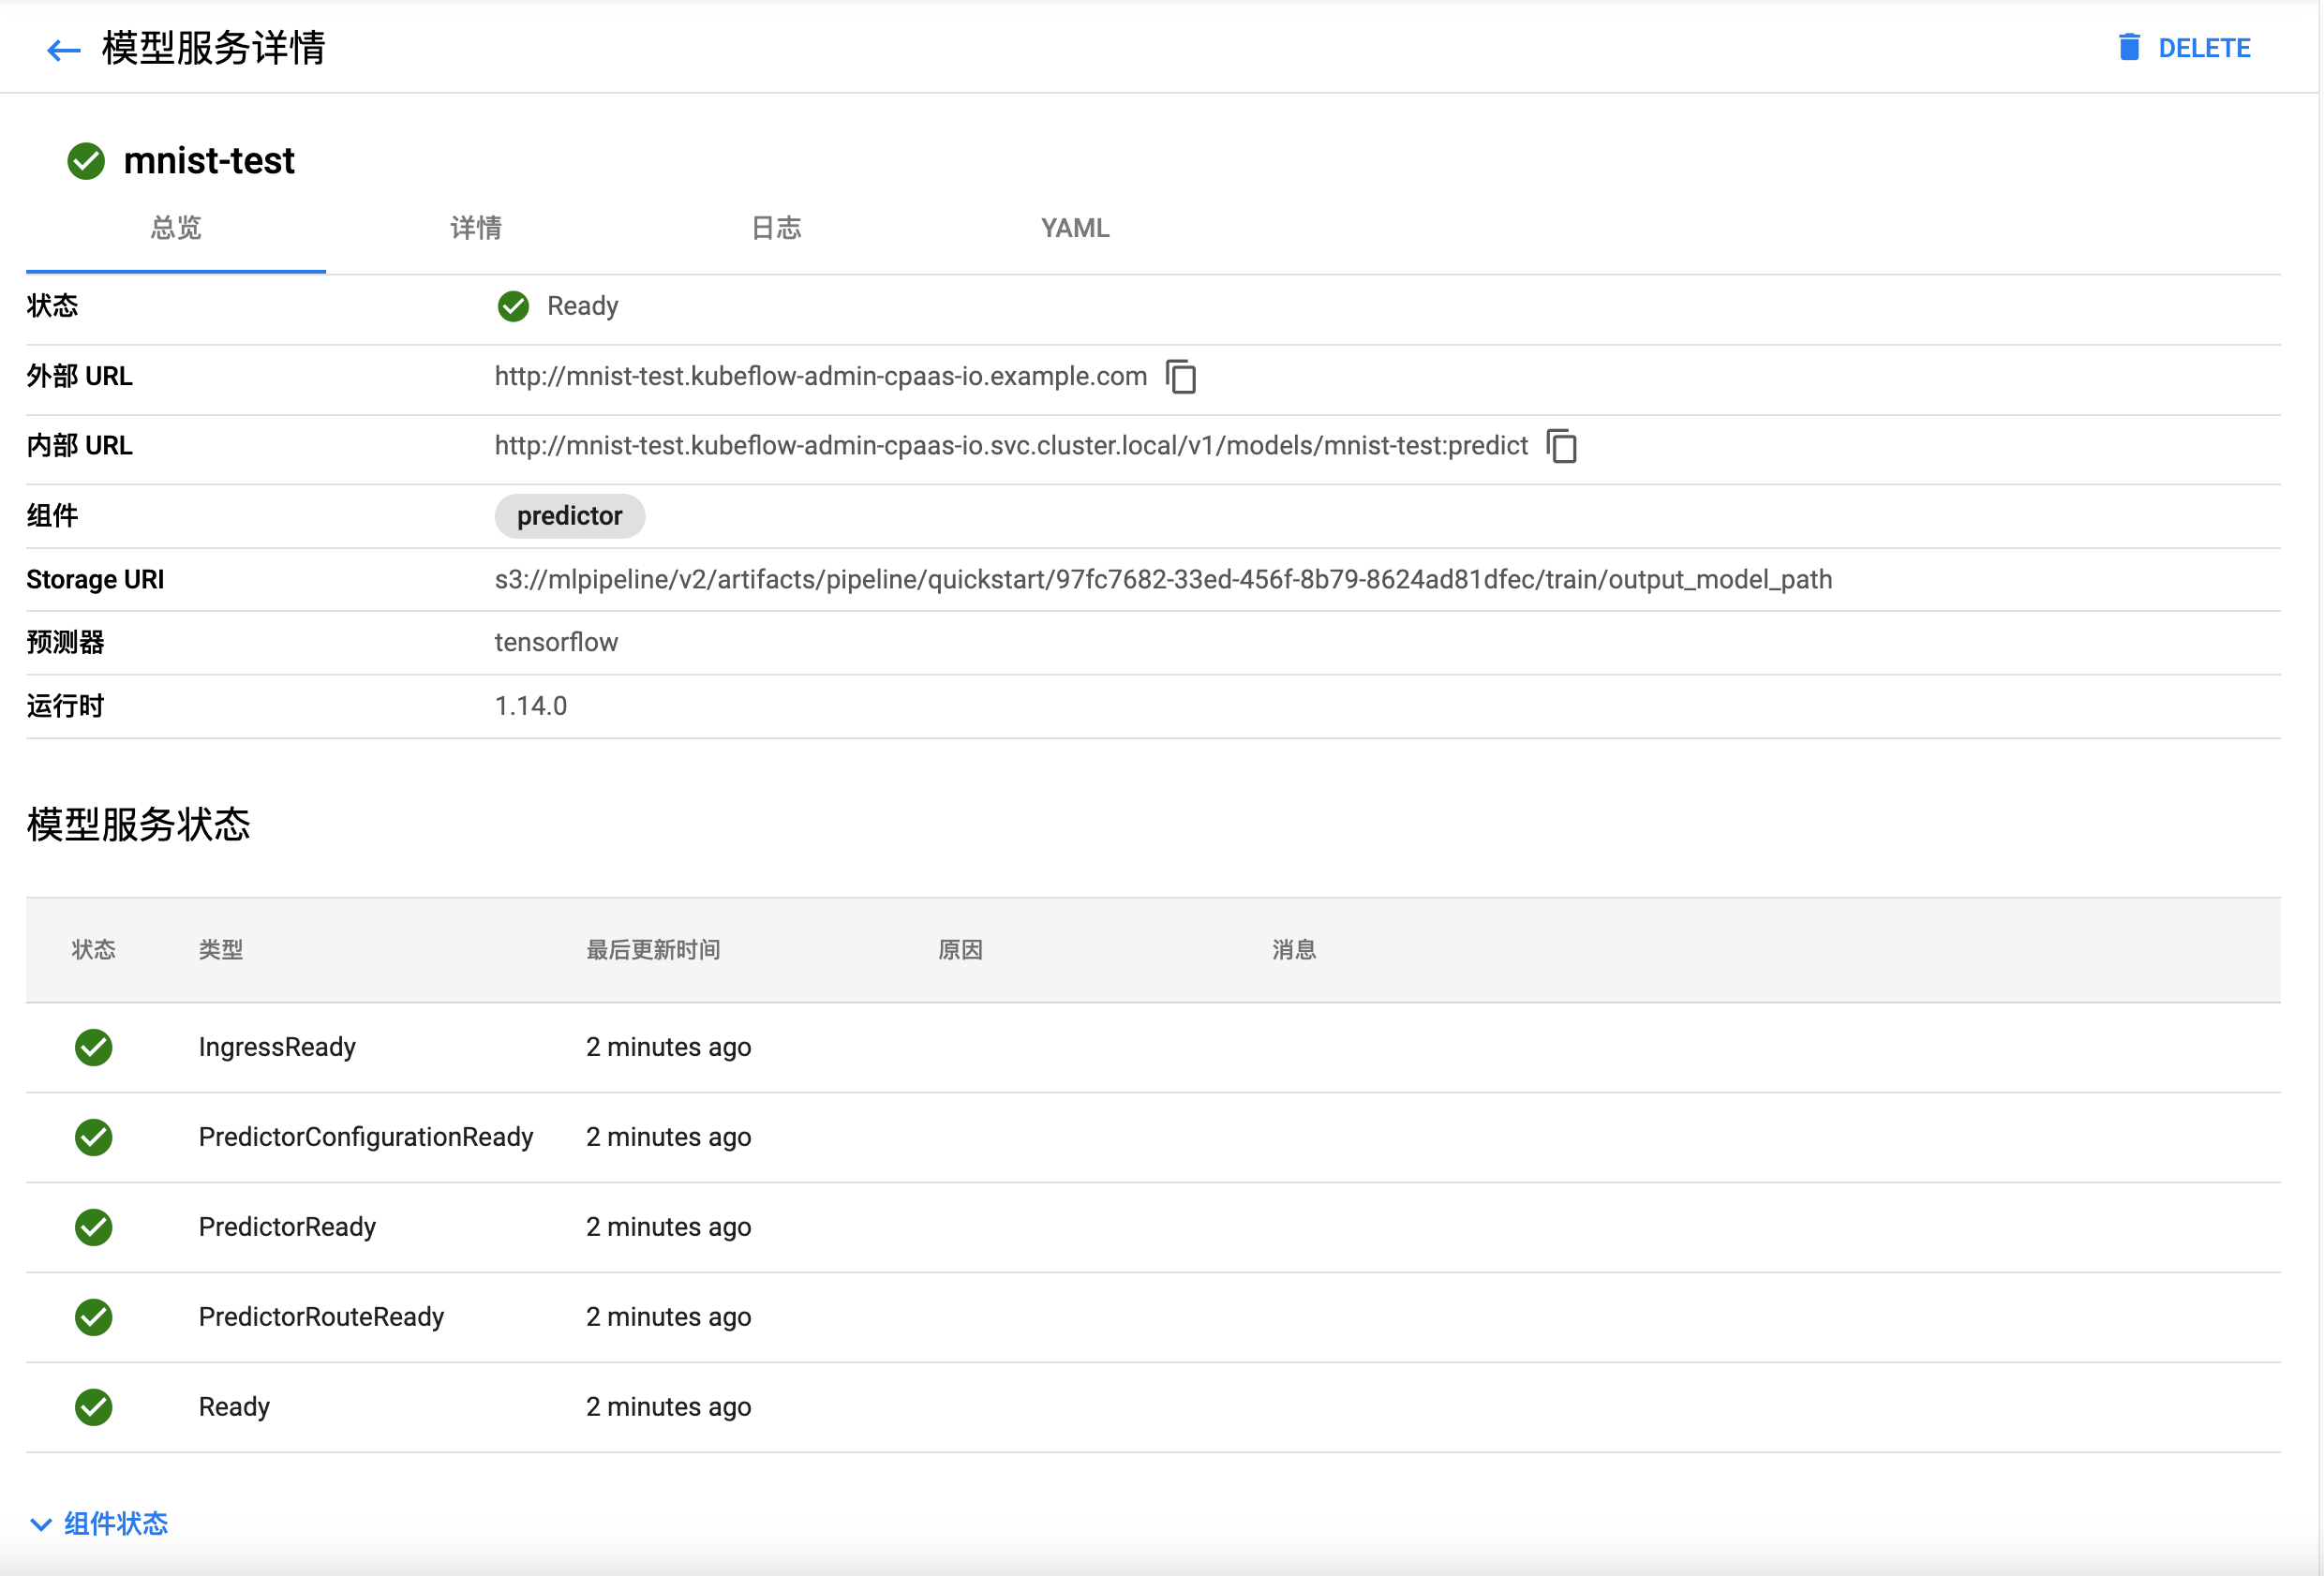

在详细信息页面中，可以获得模型服务的集群内访问地址，如：`http://mnist-test.kubeflow-admin-cpaas-io.svc.cluster.local/v1/models/mnist-test:predict`。


之后我们就可以使用 HTTP REST 接口或者 gRPC 接口访问此服务，可以通过如下的示例 Python 代码：

***注意：先确认好访问 URL 之后再执行下面访问代码***

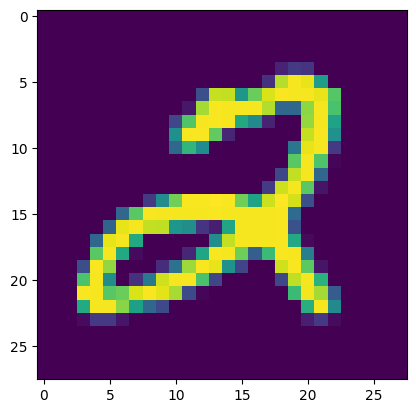

prediction: 2


In [10]:
import requests
import json
from matplotlib import pyplot as plt
import boto3

s3 = boto3.resource(
    's3',
    endpoint_url='http://minio-service.kubeflow:9000',
    aws_access_key_id='minio',
    aws_secret_access_key='minio123')
s3.Bucket('dataset').download_file('mnist/mnist-test.tfrecord-00000-of-00001', '/tmp/mnist-test.tfrecord-00000-of-00001')
files_test = ["/tmp/mnist-test.tfrecord-00000-of-00001"]
ds_test = tf.data.TFRecordDataset(files_test)
input_shape = (28, 28, 1)
num_classes = 10

def normalize_img(record):
    features = {"image": tf.io.FixedLenFeature([], tf.string), "label": tf.io.FixedLenFeature([1], tf.int64)}
    feats = tf.io.parse_single_example(record, features)
    img = tf.image.decode_image(feats["image"], channels=1, dtype=tf.uint8)
    img.set_shape(input_shape)

    label = feats["label"]
    return tf.cast(img, tf.float32) / 255.0, label

ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)

for s in ds_test:
    sample = np.array(s[0]).tolist()
    break

data = {
    "signature_name": "serving_default",
    "instances": sample
}
plt.imshow(data["instances"][0], interpolation="nearest")
plt.show()

# !!! 需要更新 service_url 之后再执行 !!!
service_url = "http://mnist-test.kubeflow-admin-cpaas-io.svc.cluster.local/v1/models/mnist-test:predict"
headers = {"content-type": "application/json"}

json_response = requests.post(service_url, data=json.dumps(data), headers=headers)
try:
    pred = json.loads(json_response.text)["predictions"][0]
    print("prediction: %d" % pred.index(max(pred)))
except:
    print("error loading result, reason: %s, response: %s" % (json_response.reason, json_response.text))

## 总结

通过以上教程，我们可以熟悉从开发，编写工作流任务，提交训练，到启动模型服务和访问的完整流程。后续章节中，您可以选择相关的部分了解更多各个部分的详细内容，包括：

- 开发训练：
  - Kubeflow Pipeline 开发
  - 实验运行，试验管理，实验追踪
  - 训练可视化
  - 分布式训练任务管理 (TFJob 或 KFP)
  - 分布式训练任务调度调优
  - 和 S3/MinIO/PVC 等数据存储系统联动
- 模型服务：
  - 启动模型服务
  - 模型服务热更新，灰度发布，版本管理
  - 模型服务自动伸缩
  - 多模型服务
  - 配置监控报警

## 附录

### 在 Notebook 增加自定义镜像

在创建 Notebook 时需要选择使用的镜像，如上所示，这些镜像中包含特定版本的机器学习框架、依赖、工具等。
如果现有的镜像中包含的机器学习框架、依赖、工具等不符合现有的项目要求，比如需要更新版本的 tensorflow、keras等。
这时如果直接在 Notebook 中升级这些依赖，那么当 Notebook 相应的 pods 重启后，这些高版本的依赖还是会被还原，
因此最好的方法是**以现有的镜像为基础**，安装需要的框架、依赖、工具，从而构建出新的镜像。这样当 Notebook 相应的 pods 重启后，
还是可以使用新的框架、依赖、工具等。

当构建出新的镜像后，需要修改一下相关的 ConfigMap，确保在创建 Notebook 时可以需要新的镜像。
具体来说就是在 ConfigMap `jupyter-web-app-config-hmg7g9826g` 中增加新的镜像。
例如新的镜像是 kubeflow/test-tensorflow-full:v1.6.1，
在路径 data -> spawner_ui_config.yaml: -> spawnerFormDefaults -> image -> options 下增加 kubeflow/test-tensorflow-full:v1.6.1 即可
如下所示：

```yaml
apiVersion: v1
data:
  spawner_ui_config.yaml: |
    spawnerFormDefaults:
      image:
        value: typhoon1986/mlops-ide:3.15.0
        options:
        - kubeflow/test-tensorflow-full:v1.6.1
        ...
      imageGroupOne:
      ...
```

修改 ConfigMap 之后重启 jupyter web app 相关的 pods 即可。

> notes：在构建新镜像是一定要以现有的镜像为基础镜像，否则可能会出现 jupyter web app 加载不了 Notebook 的页面
